In [1]:
import matplotlib
import matplotlib.pyplot as plt
# import tensorflow as tf
# import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
import os
import random
import pandas as pd
# from scipy import ndimage
# from skimage.util import img_as_ubyte
import time
from scipy.spatial.distance import cdist

from proglearn.sims.gaussian_sim import _generate_2d_rotation
from proglearn.forest import LifelongClassificationForest
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer
from proglearn.voters import TreeClassificationVoter

# from skimage.transform import rotate
from multiprocessing import Pool
from functools import partial
import ot
from sklearn.neighbors import BallTree
import SimpleITK as sitk
from graspologic.align import OrthogonalProcrustes, SeedlessProcrustes

In [2]:
context = sns.plotting_context(context="poster", font_scale=1)
sns.set_context(context)

In [3]:
def generate_posteriors(X, task_id, forest, transformers):
    vote_per_transformer_id = []
    for transformer_id in transformers:
        vote_per_bag_id = []
        for bag_id in range(
            len(forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id])
        ):
            transformer = forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id][
                bag_id
            ]
            X_transformed = transformer.transform(X)
            voter = forest.task_id_to_decider[task_id].transformer_id_to_voters_[transformer_id][bag_id]
            vote = voter.predict_proba(X_transformed)
            vote_per_bag_id.append(vote)
        vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

    return vote_per_transformer_id

In [4]:
def vote_to_pred(vote, test_task, test_grid):
    tree = BallTree(test_grid)
    pred = np.zeros(test_task.shape)
    ind = tree.query(test_task.reshape(-1,2), k=1, return_distance=False)
    for i in range(len(test_task)):
        pred[i,0] = vote[ind[i]]
        pred[i,1] = 1 - pred[i,0]
        
    return pred

In [5]:
def reshape_posteriors(inside, task):
    inside_ravel = inside.ravel()
    preds = np.zeros(inside_ravel.shape)
    j = 0
    for i in range(len(inside_ravel)):
        if inside_ravel[i]:
            preds[i] = task[j]
            j += 1
    preds = preds.reshape(inside.shape)
    
    return preds

In [6]:
def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

In [7]:
def init_forest(max_depth, n_cls):
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(n_cls)}
    l2f = ProgressiveLearner(default_transformer_class = default_transformer_class,
            default_transformer_kwargs = default_transformer_kwargs,
            default_voter_class = default_voter_class,
            default_voter_kwargs = default_voter_kwargs,
            default_decider_class = default_decider_class,
            default_decider_kwargs = default_decider_kwargs)
    return l2f

In [8]:
def get_random_pt(xlim_, ylim_):
    x = random.uniform(xlim_[0], xlim_[1])
    y = random.uniform(ylim_[0], ylim_[1])
    return x,y

def generate_rand_ellipse(n_sample):
    task_n_sample = n_sample / 2
    data = []
    label = []
    max_ite = 10000
    xlim_ = [-6,6]
    ylim_ = [-3,3]
    ite = 0
    # 5*2\pi - (6*3\pi - 5*2\pi) = 2\pi --> (5-x)(2-x) = 2
    width = np.roots([1,-7,8])[1]
    while (label.count(0) < task_n_sample) or (label.count(1) < task_n_sample):
        if ite < max_ite:
            x,y = get_random_pt(xlim_, ylim_)
            if label.count(0) < task_n_sample:
                if (x**2 / 6**2 + y**2 / 3**2 < 1) & (x**2 / 5**2 + y**2 / 2**2 > 1):
                    data.append([x,y])
                    label.append(0)
            if label.count(1) < task_n_sample:
                if (x**2 / (5-width)**2 + y**2 / (2-width)**2 > 1) & (x**2 / 5**2 + y**2 / 2**2 < 1):
                    data.append([x,y])
                    label.append(1)
            ite += 1
        else:
            break
    return np.array(data), np.array(label)

In [9]:
def rotate_data(X, theta):
    R = np.array([[np.cos(theta), np.sin(theta)],
                  [-np.sin(theta), np.cos(theta)]])
    X = X @ R
    return X

In [10]:
def shear_data_rot(X, theta):
    R = np.array([[1, 0],
                  [np.tan(theta), 1]])
    X = X @ R
    return rotate_data(X, theta)

def shear_data(X, theta):
    R = np.array([[1, 0],
                  [np.tan(theta), 1]])
    X = X @ R
    return X

# def shear_data(X, s, dim=[0,1]):
#     #dimensions to shear
#     Z = X[:, dim]

#     #shear
#     R = np.array([[1, 0], [s, 1]])
#     Z = Z @ R
    
#     #recombine
#     X[:, dim] = Z
    
#     return X

def double_shearX(X, y, ss=(0,0) , dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    i,j = dim
    t,b = ss
    
    Z_top = Z[Z[:,j] >= 0]
    Z_bot = Z[Z[:,j] < 0]
    
    #shear
    R_top = np.array([[1, 0], [t, 1]])
    R_bot = np.array([[1, 0], [b, 1]])
    Z_top = Z_top @ R_top
    Z_bot = Z_bot @ R_bot
    
    #recombine
    Z_new = np.concatenate((Z_top, Z_bot))
    X[:, dim] = Z_new
    if y is not None:
        c_top = y[Z[:,j] >= 0]
        c_bot = y[Z[:,j] < 0]
        y = np.concatenate((c_top, c_bot))
    
        return X, y
    return X

In [11]:
# def exp_reg_pos_asPt(angle, transform, n_trees=10, n_samples_source=500):
#     angle = np.pi*angle/180
#     train_x1, train_y1 = generate_rand_ellipse(n_samples_source)
#     train_x2, train_y2 = generate_rand_ellipse(n_samples_source)
#     test_x1, test_y1 = generate_rand_ellipse(n_samples_source)
#     test_x2, test_y2 = generate_rand_ellipse(n_samples_source)

#     if transform == 0:  # rotation (rigid)
#         train_x2_rot = rotate_data(train_x2, angle)
#         test_x2_rot = rotate_data(test_x2, angle)
#     elif transform == 1:  # rotation + shear (affine)
#         train_x2_rot = shear_data_rot(train_x2, angle)
#         test_x2_rot = shear_data_rot(test_x2, angle)
#     elif transform == 2:  # double shear (non-linear)
#         train_x2_rot,train_y2 = double_shearX(train_x2, train_y2, ss=(np.tan(angle), 0))
#         test_x2_rot,test_y2 = double_shearX(test_x2, test_y2, ss=(np.tan(angle), 0))

#     max_depth = ceil(log2(n_samples_source))
#     l2f = init_forest(max_depth, 2) 
#     uf = init_forest(max_depth, 2)
#     l2f.add_task(train_x1, train_y1, num_transformers=n_trees)
#     l2f.add_task(train_x2_rot, train_y2, num_transformers=n_trees)
#     uf.add_task(train_x1, train_y1, num_transformers=2*n_trees)
#     uf.add_task(train_x2_rot, train_y2, num_transformers=2*n_trees)

#     # L2F
#     l2f_task1 = generate_posteriors(test_x1, 0, l2f, [0,1])
#     l2f_task2 = generate_posteriors(test_x2_rot, 1, l2f, [0,1])

#     errors = np.zeros(6,dtype=float)
#     l2f_pred_task1 = np.mean([l2f_task1[0], l2f_task1[1]], axis=0)
#     errors[2] = 1 -\
#         np.mean(np.argmax(l2f_pred_task1, axis=1) == test_y1)
#     l2f_pred_task2 = np.mean([l2f_task2[0], l2f_task2[1]], axis=0)
#     errors[3] = 1 -\
#         np.mean(np.argmax(l2f_pred_task2, axis=1) == test_y2)

#     # UF
#     uf_task1 = uf.predict(test_x1, transformer_ids=[0], task_id=0)
#     uf_task2 = uf.predict(test_x2_rot, transformer_ids=[1], task_id=1)
#     errors[0] = 1 - np.mean(uf_task1 == test_y1)
#     errors[1] = 1 - np.mean(uf_task2 == test_y2)

#     # procrustes
#     aligner = SeedlessProcrustes(iterative_num_reps=500)
#     aligner.fit(l2f_task1[0], l2f_task2[1])
#     Q_ = aligner.initial_Q
#     aligner = SeedlessProcrustes(iterative_num_reps=500, init='custom', initial_Q=Q_)
#     deformed_task1 = aligner.fit_transform(l2f_task1[0], l2f_task2[1])
    
#     aligner1 = SeedlessProcrustes(iterative_num_reps=500)
#     aligner1.fit(l2f_task2[1], l2f_task1[0])
#     Q_ = aligner1.initial_Q
#     aligner1 = SeedlessProcrustes(iterative_num_reps=500, init='custom', initial_Q=Q_)
#     deformed_task2 = aligner1.fit_transform(l2f_task2[1], l2f_task1[0])
    
#     l2f_pred_task1_proc = np.mean([l2f_task1[0], deformed_task1], axis=0)
#     errors[4] = 1 - np.mean(np.argmax(l2f_pred_task1_proc, axis=1) == test_y1)
#     l2f_pred_task2_proc = np.mean([l2f_task2[1], deformed_task2], axis=0)
#     errors[5] = 1 - np.mean(np.argmax(l2f_pred_task2_proc, axis=1) == test_y2)
#     return errors

In [48]:
def exp(angle, n_trees=10, n_samples_source=200):
    angle = np.pi*angle/180
    train_x1, train_y1 = generate_rand_ellipse(n_samples_source)
    train_x2, train_y2 = generate_rand_ellipse(n_samples_source)
#     train_x2_rot = rotate_data(train_x2, angle)
#     train_x2_rot = shear_data_rot(train_x2, angle)
    train_x2_rot,train_y2 = double_shearX(train_x2, train_y2,
                                          ss=(np.tan(angle), -np.tan(angle)))

    test_x1, test_y1 = generate_rand_ellipse(n_samples_source)
    test_x2, test_y2 = generate_rand_ellipse(n_samples_source)
#     test_x2_rot = rotate_data(test_x2, angle)
#     test_x2_rot = shear_data_rot(test_x2, angle)
    test_x2_rot,test_y2 = double_shearX(test_x2, test_y2,
                                        ss=(np.tan(angle), -np.tan(angle)))
    
    errors = np.zeros(4, dtype=float)
    max_depth = ceil(log2(n_samples_source))
    l2f = init_forest(max_depth, 2) 
    uf = init_forest(max_depth, 2)
    l2f.add_task(train_x1, train_y1, num_transformers=n_trees)
    l2f.add_task(train_x2_rot, train_y2, num_transformers=n_trees)
    uf.add_task(train_x1, train_y1, num_transformers=2*n_trees)
    uf.add_task(train_x2_rot, train_y2, num_transformers=2*n_trees)
    uf_task1 = uf.predict(test_x1, transformer_ids=[0], task_id=0)
    l2f_task1 = l2f.predict(test_x1, task_id=0)
    uf_task2 = uf.predict(test_x2_rot, transformer_ids=[1], task_id=1)
    l2f_task2 = l2f.predict(test_x2_rot, task_id=1)

    # UF
    errors[0] = 1 - np.mean(uf_task1 == test_y1)
    errors[1] = 1 - np.mean(uf_task2 == test_y2)
    # L2F
    errors[2] = 1 - np.mean(l2f_task1 == test_y1)
    errors[3] = 1 - np.mean(l2f_task2 == test_y2)

    return errors


In [118]:
# pickle_in = open("store/errors_TE-ellipse-OT-reg-data.pickle", "rb")
# errors_reg_data = pickle.load(pickle_in)

In [68]:
def error_to_te(e_avg, n_angles=13):
    mean_te_all = []
    for n_alg in range(2):
        e_single = np.hstack((e_avg[:,:2], e_avg[:,n_alg*2+2:n_alg*2+4]))
        mean_te = np.zeros((2, n_angles))
        for i in range(mean_te.shape[0]):
            for j in range(mean_te.shape[1]):
                mean_te[i,j] = e_single[j,i] / e_single[j,i+2]
        mean_te_all.append(mean_te)
    return mean_te_all

In [92]:
pickle_in = open("store/errors_TE-ellipse-sitk-reg-pos-asImg-Rig.pickle", "rb")
Img0 = pickle.load(pickle_in)

In [235]:
pickle_in = open("store/errors_TE-ellipse-OT-reg-pos-asPt.pickle", "rb")
Pt_ = pickle.load(pickle_in)
Pt0 = [Pt_['0-SP'], Pt_['0-OT']]
pickle_in = open("store/errors_TE-ellipse-OT-reg-pos-asImg.pickle", "rb")
Grid_ = pickle.load(pickle_in)
Grid0 = Grid_[0]
pickle_in = open("store/errors_TE-ellipse-sitk-reg-pos-asImg-trans0.pickle", "rb")
Img0_1 = np.mean(pickle.load(pickle_in), axis=0)
pickle_in = open("store/errors_TE-ellipse-sitk-reg-pos-asImg-trans0_75105120.pickle", "rb")
Img0_2 = np.mean(pickle.load(pickle_in), axis=0)

In [236]:
Img0 = np.zeros((13,6))
Img0[:5,:] = Img0_1[:5,:].copy()
Img0[5,:] = Img0_2[0,:].copy()
Img0[6,:] = Img0_1[5,:].copy()
Img0[7:9,:] = Img0_2[1:3,:].copy()
Img0[9:13,:] = Img0_1[7:11,:].copy()

In [98]:
# retrieve & plot results
results = {}

In [100]:
# r = [Img0, np.mean(Pt0[0], axis=0), np.mean(Pt0[1], axis=0), np.mean(Grid0, axis=0)]
r = [np.mean(Img0, axis=0)]
trans = 0
results[trans] = []
for alg in range(len(r)):
    results[trans].append(error_to_te(r[alg]))

In [239]:
# Pt1 = [Pt_['1-SP'], Pt_['1-OT']]
# Grid1 = Grid_[1]
# pickle_in = open("store/errors_TE-ellipse-sitk-reg-pos-asImg-trans1.pickle", "rb")
# Img1 = pickle.load(pickle_in)

In [101]:
# r = [np.mean(Img1, axis=0),
#      np.mean(Pt1[0], axis=0), np.mean(Pt1[1], axis=0),
#      np.mean(Grid1, axis=0)]
r = [np.mean(Img1, axis=0)]
trans = 1
results[trans] = []
for alg in range(len(r)):
    results[trans].append(error_to_te(r[alg], 12))

In [241]:
# Pt2 = [Pt_['2-SP'], Pt_['2-OT']]
# Grid2 = Grid_[2]
# pickle_in = open("store/errors_TE-ellipse-sitk-reg-pos-asImg-trans2.pickle", "rb")
# Img2 = pickle.load(pickle_in)

In [102]:
# r = [np.mean(Img2, axis=0),
#      np.mean(Pt2[0], axis=0), np.mean(Pt2[1], axis=0),
#      np.mean(Grid2, axis=0)]
r = [np.mean(Img2, axis=0)]
trans = 2
results[trans] = []
for alg in range(len(r)):
    results[trans].append(error_to_te(r[alg], 12))

In [15]:
# def non_linear_trans(X, theta1, theta2=0):
#     X1 = shear_data(X, theta1)
#     X2 = shear_data(X, theta2)
# #     if theta1 > np.pi/2:
# #         X2[:,0] = -X2[:,0]
#     idx = np.where(X[:,0] > 0)[0]
#     X1[idx,:] = X2[idx,:].copy()
#     return X1

<ipython-input-439-33cad07197e6>:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparancy" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('shear_data', transparancy=False, facecolor='white')


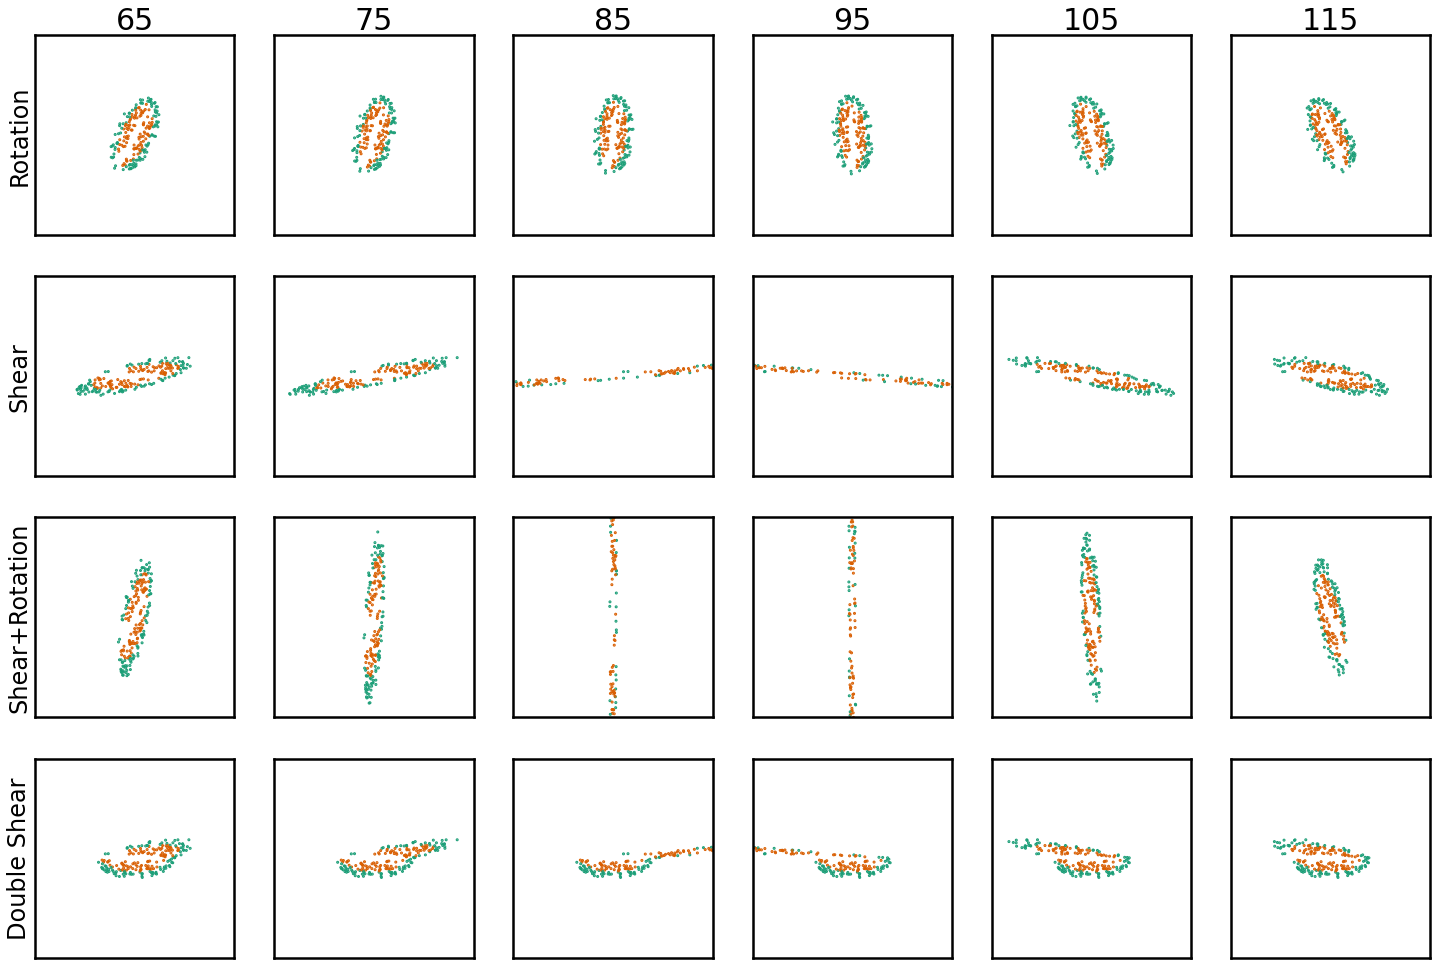

In [439]:
colors = sns.color_palette('Dark2', n_colors=5)
angles = [65,75,85,95,105,115]
fig,axs = plt.subplots(4,len(angles),figsize=(25,17))
titles = ['Rotation', 'Shear', 'Shear+Rotation', 'Double Shear']
n = 200
train_x1, train_y1 = generate_rand_ellipse(n)
train_x2, train_y2 = generate_rand_ellipse(n)
for a in range(len(angles)):
    angle = np.pi*angles[a]/180
    train_x2_rot = rotate_data(train_x2.copy(), angle)
    train_x2_skew2 = shear_data_rot(train_x2.copy(), angle)
    angle = np.tan(np.pi*angles[a]/180)
    train_x2_skew1 = shear_data(train_x2.copy(), angle)
    train_x2_non_l,train_y2_new = double_shearX(train_x2.copy(), train_y2.copy(), ss=(angle, 0))
    data = [train_x2_rot, train_x2_skew1, train_x2_skew2, train_x2_non_l]
    labels = [train_y2.copy(), train_y2.copy(), train_y2.copy(), train_y2_new.copy()]
    for i in range(len(data)):
        ax = axs[i,a]
#         clr = [colors[ii] for ii in labels[i].copy()]
        ax.scatter(data[i][:, 0], data[i][:, 1], c=get_colors(colors[:2], labels[i].copy()), s=1)
        ax.set(yticklabels='', yticks=[], xticklabels='', xticks=[])
        ax.set_xlim([-15,15]); ax.set_ylim([-15,15])
        ax.set_aspect('equal', adjustable='box')
        if i == 0:
            ax.set_title(angles[a], fontsize=30, pad=5)
        if a == 0:
            ax.set_ylabel(titles[i])
plt.savefig('shear_data', transparancy=False, facecolor='white')

In [114]:
angle = np.pi*65/180
n = 200
train_x1, train_y1 = generate_rand_ellipse(n)
train_x2, train_y2 = generate_rand_ellipse(n)
train_x2_rot = rotate_data(train_x2.copy(), angle)
train_x2_skew = shear_data(train_x2.copy(), angle)
train_x2_non_l,train_y2_new = double_shearX(train_x2.copy(), train_y2.copy(),
                                            ss=(np.tan(angle), np.tan(-angle)))


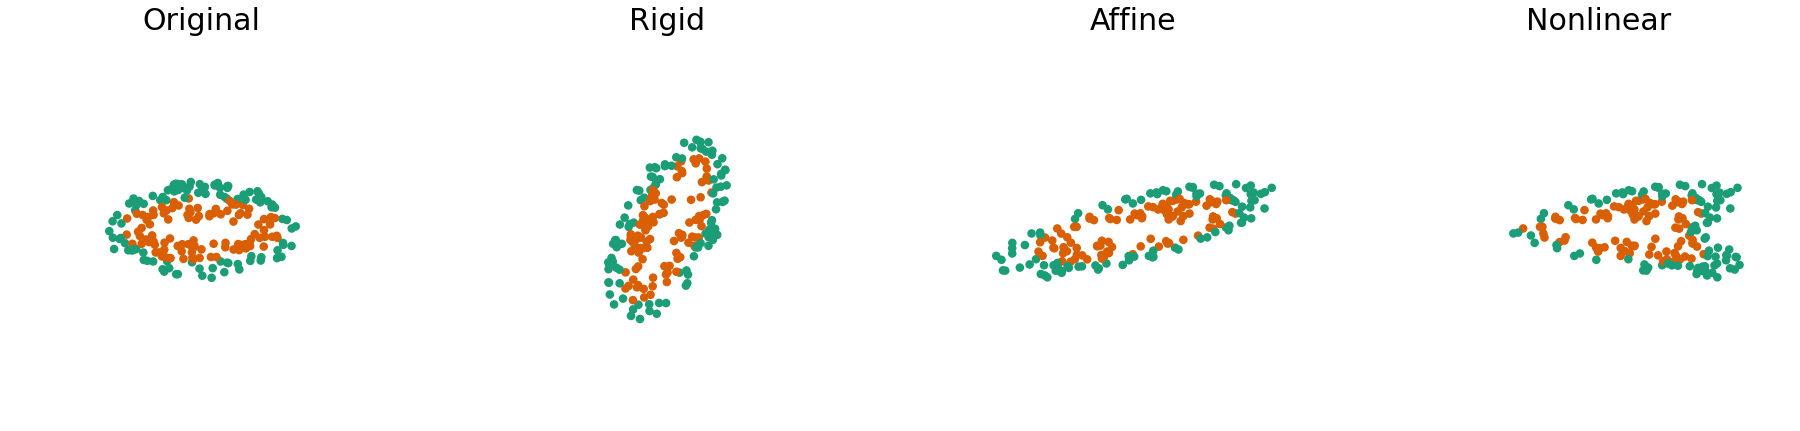

In [115]:
sns.set_context("talk")
colors = sns.color_palette('Dark2', n_colors=2)
fig,axs = plt.subplots(1,4,figsize=(32,8))
data = [train_x1, train_x2_rot, train_x2_skew, train_x2_non_l]
label = [train_y1, train_y2, train_y2, train_y2_new]
titles = ['Original', 'Rigid', 'Affine', 'Nonlinear']
for i in range(len(data)):
    ax = axs[i]
    clr = [colors[ii] for ii in label[i]]
    ax.scatter(data[i][:, 0], data[i][:, 1], c=clr, s=50)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=30, pad=0)
    ax.axis('off')
    ax.set_xlim([-12,12]); ax.set_ylim([-12,12])
    ax.set_aspect('equal', adjustable='box')

In [134]:
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec

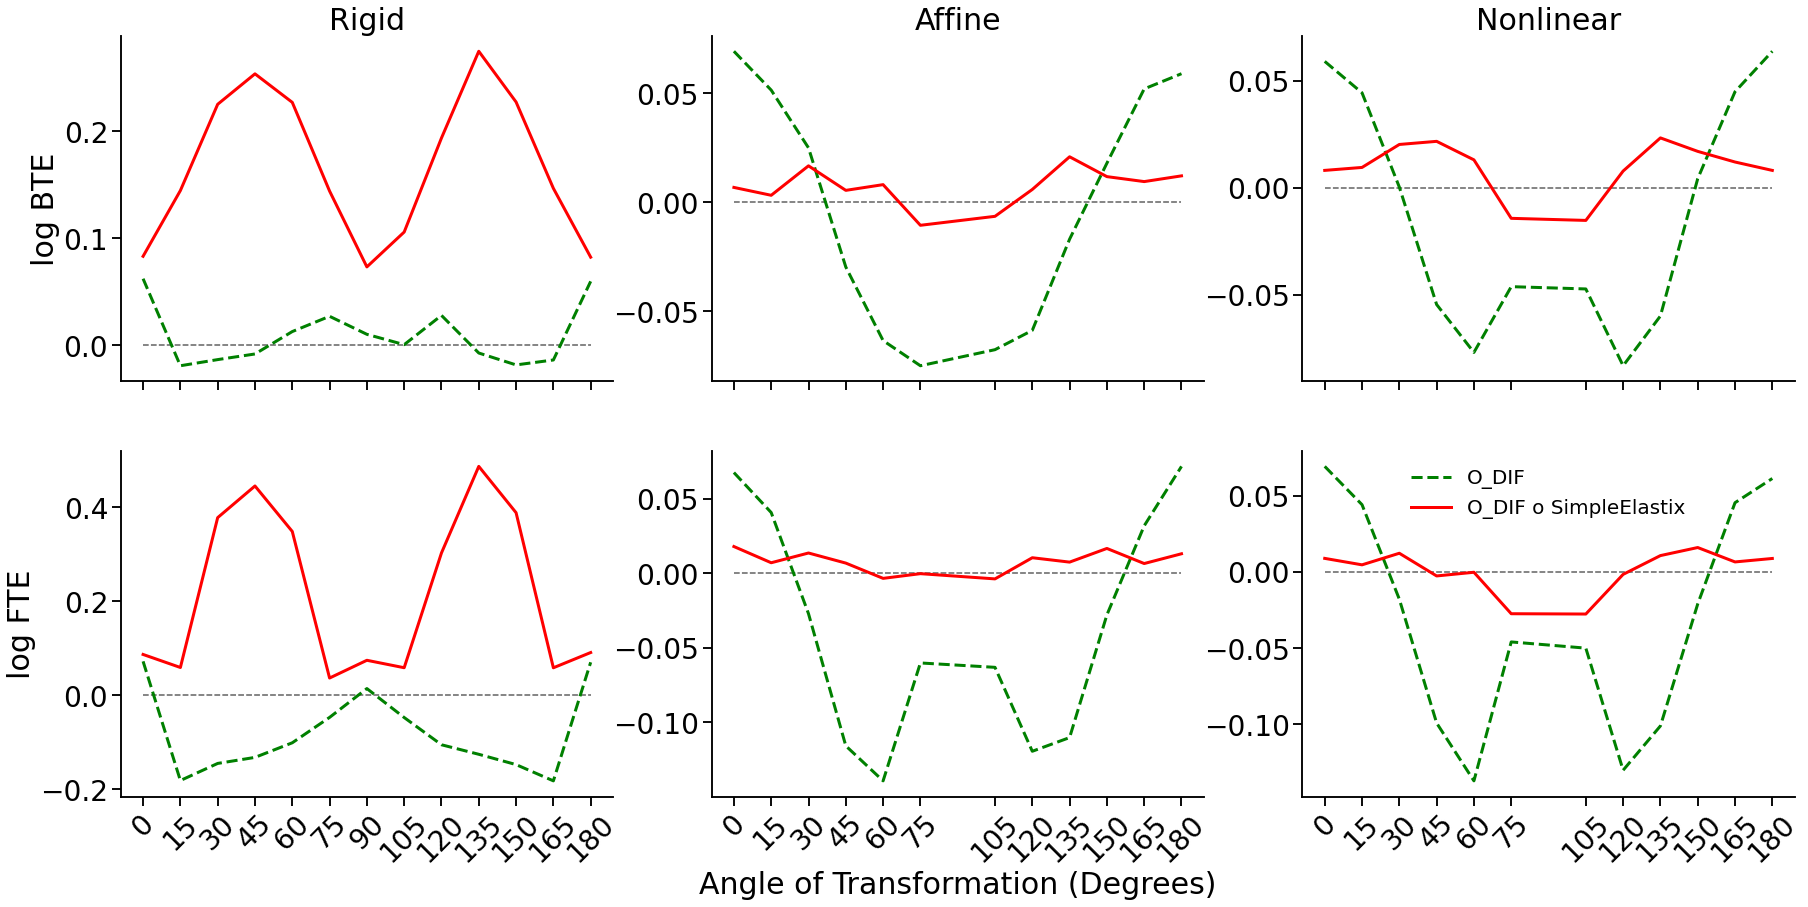

In [112]:
# colors = sns.color_palette('Dark2', n_colors=5)
colors = ['g','r']
fontsize=30; labelsize=28
fig, axs = plt.subplots(2,3, figsize=(30,14))
angles = [range(0,195,15), [0,15,30,45,60,75,105,120,135,150,165,180], [0,15,30,45,60,75,105,120,135,150,165,180]]
ylabels = ['log BTE','log FTE']
titles = ['Rigid', 'Affine', 'Nonlinear']
labels = ['O_DIF', 'O_DIF o SimpleElastix', 'Pt(SP)','Pt(OT)','Grid']
line_styles = ['dashed','-','-','-','-']
for i in range(3):
    data = []
    data.append(results[i][0][0].copy())
    for ii in range(len(results[i])):
        data.append(results[i][ii][1].copy())
    for j in range(2):
        ax = axs[j,i]
        for data_idx in range(len(data)):
            ax.plot(
                angles[i], np.log(data[data_idx][j]),label=labels[data_idx],
                lw=3, c=colors[data_idx], ls=line_styles[data_idx]
            )
            ax.set_xticks(angles[i])
            ax.set_xticklabels(angles[i], rotation=45)
            if i == 0:
                ax.set_ylabel(ylabels[j], fontsize=fontsize)
            ax.tick_params(labelsize=labelsize)
            ax.hlines(0, angles[i][0], angles[i][-1], colors='gray', linestyles='dashed',linewidth=1.5)
            right_side = ax.spines["right"]
            right_side.set_visible(False)
            top_side = ax.spines["top"]
            top_side.set_visible(False)
            if j == 0:
                ax.set_xticklabels("")
                ax.set_title(titles[i], fontsize=fontsize)
            else:
                if i == 1:
                    ax.set_xlabel('Angle of Transformation (Degrees)', fontsize=fontsize)
                if i == 2:
                    ax.legend(loc='upper center', fontsize=20, frameon=False)
#             if i==1 and j==0:
#                 ax.set_yscale('symlog', linthresh=0.1)
plt.savefig('ellipse-TEs')


#### OT reg images

In [11]:
def to_grid_in_cir(test_task1, test_task2):
    h = 0.1
    # compute largest distance to origin
    dists = cdist(np.vstack((test_task1, test_task2)), np.array([[0,0]]))
    radius = np.max(dists)
    x, y = np.meshgrid(np.arange(-radius, radius, h), np.arange(-radius, radius, h))
    r = x**2 + y**2  # centered at (0,0)
    inside = r <= radius**2 + 0.1
    x_cir = x[inside]  # can also use np.ma.masked_less_equal(r,1).data
    y_cir = y[inside]
    return x, y, inside, np.array([x_cir, y_cir]).T, radius

In [12]:
def get_data(angle, transform, n_samples_source, n_trees):
    angle = np.pi*angle/180
    train_x1, train_y1 = generate_rand_ellipse(n_samples_source)
    train_x2, train_y2 = generate_rand_ellipse(n_samples_source)
    test_x1, test_y1 = generate_rand_ellipse(n_samples_source)
    test_x2, test_y2 = generate_rand_ellipse(n_samples_source)
    
    if transform == 0:  # rotation (rigid)
        train_x2_rot = rotate_data(train_x2, angle)
        test_x2_rot = rotate_data(test_x2, angle)
    elif transform == 1:  # shear (affine)
        train_x2_rot = shear_data(train_x2, angle)
        test_x2_rot = shear_data(test_x2, angle)
    elif transform == 2:  # double shear (non-linear)
        train_x2_rot,train_y2 = double_shearX(train_x2, train_y2, ss=(np.tan(angle), np.tan(-angle)))
        test_x2_rot,test_y2 = double_shearX(test_x2, test_y2, ss=(np.tan(angle), np.tan(-angle)))
    data = [test_x1,test_y1,test_x2_rot,test_y2]
    
    max_depth = ceil(log2(n_samples_source))
    l2f = init_forest(max_depth, 2) 
    uf = init_forest(max_depth, 2)
    l2f.add_task(train_x1, train_y1, num_transformers=n_trees)
    l2f.add_task(train_x2_rot, train_y2, num_transformers=n_trees)
    uf.add_task(train_x1, train_y1, num_transformers=2*n_trees)
    uf.add_task(train_x2_rot, train_y2, num_transformers=2*n_trees)
    return data, l2f, uf

In [13]:
def pred_on_grid(angle, transform, n_trees=10, n_samples_source=200):
    [test_x1,test_y1,test_x2_rot,test_y2], l2f, uf =\
        get_data(angle, transform, n_samples_source, n_trees)
    _, _, inside, test_grid, _ = to_grid_in_cir(test_x1, test_x2_rot)

    # L2F
    l2f_task1_pos = generate_posteriors(test_grid, 0, l2f, [0,1])
    l2f_task2_pos = generate_posteriors(test_grid, 1, l2f, [0,1])
    task1pred1_reshaped = reshape_posteriors(inside, l2f_task1_pos[0][:,0])
    task1pred2_reshaped = reshape_posteriors(inside, l2f_task1_pos[1][:,0])
    task2pred1_reshaped = reshape_posteriors(inside, l2f_task2_pos[0][:,0])
    task2pred2_reshaped = reshape_posteriors(inside, l2f_task2_pos[1][:,0])
    posteriors = [task1pred1_reshaped, task2pred2_reshaped]
    
    uf_task1_pos = generate_posteriors(test_grid, 0, uf, [0])
    uf_task2_pos = generate_posteriors(test_grid, 1, uf, [1])
    task1pred1_reshaped_uf = reshape_posteriors(inside, uf_task1_pos[0][:,0])
    task2pred1_reshaped_uf = reshape_posteriors(inside, uf_task2_pos[0][:,0])

    errors = np.zeros(6, dtype=float)
    # L2F
    l2f_pred_task1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)[inside]
    l2f_task1 = vote_to_pred(l2f_pred_task1, test_x1, test_grid)
    errors[2] = 1-np.mean(np.argmax(l2f_task1, axis=1) == test_y1)
    l2f_pred_task2 = np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0)[inside]
    l2f_task2 = vote_to_pred(l2f_pred_task2, test_x2_rot, test_grid)
    errors[3] = 1-np.mean(np.argmax(l2f_task2, axis=1) == test_y2)
    # UF
    uf_pred_task1 = task1pred1_reshaped_uf[inside]
    uf_task1 = vote_to_pred(uf_pred_task1, test_x1, test_grid)
    errors[0] = 1-np.mean(np.argmax(uf_task1, axis=1) == test_y1)
    uf_pred_task2 = task2pred1_reshaped_uf[inside]
    uf_task2 = vote_to_pred(uf_pred_task2, test_x2_rot, test_grid)
    errors[1] = 1-np.mean(np.argmax(uf_task2, axis=1) == test_y2)
    
    return ([test_x1,test_y1,test_x2_rot,test_y2], posteriors, [inside,test_grid], errors)

In [14]:
def to_test_grid(transform, angle):
    xlim_ = [-6, 6]
    ylim_ = [-3, 3]
    h = 0.5
    x, y = np.meshgrid(np.arange(xlim_[0], xlim_[1]+h, h),
                       np.arange(ylim_[0], ylim_[1]+h, h))
    r =  x**2 / xlim_[1]**2 + y**2 / ylim_[1]**2
    inside = r <= 1
    x_in = x[inside]
    y_in = y[inside]
    test_grid_ori = np.array([x_in, y_in]).T
    angle = np.pi * angle / 180
    if transform == 0:
        test_grid_trans = rotate_data(test_grid_ori, angle)
    elif transform == 1:
        test_grid_trans = shear_data_rot(test_grid_ori, angle)
    elif transform == 2:
        test_grid_trans = double_shearX(test_grid_ori, None, ss=(np.tan(angle), np.tan(-angle)))
    return test_grid_ori, test_grid_trans


In [25]:
def exp_reg_pos_asImg_OP(angle, transform, n_trees=10, n_samples_source=200):
    [test_x1,test_y1,test_x2_rot,test_y2], l2f, uf =\
        get_data(angle, transform, n_samples_source, n_trees)   
    test_grid_ori, test_grid_trans = to_test_grid(transform, angle)
    
    l2f_task1_pos = generate_posteriors(test_grid_ori, 0, l2f, [0,1])
    l2f_task2_pos = generate_posteriors(test_grid_trans, 1, l2f, [0,1])
    uf_task1_pos = generate_posteriors(test_grid_ori, 0, uf, [0])
    uf_task2_pos = generate_posteriors(test_grid_trans, 1, uf, [1])

    errors = np.zeros(6, dtype=float)
    # L2F
    l2f_pred_task1 = np.mean([l2f_task1_pos[0], l2f_task1_pos[1]], axis=0)
    l2f_task1 = vote_to_pred(l2f_pred_task1[:,0], test_x1, test_grid_ori)
    errors[2] = 1-np.mean(np.argmax(l2f_task1, axis=1) == test_y1)
    l2f_pred_task2 = np.mean([l2f_task2_pos[0], l2f_task2_pos[1]], axis=0)
    l2f_task2 = vote_to_pred(l2f_pred_task2[:,0], test_x2_rot, test_grid_trans)
    errors[3] = 1-np.mean(np.argmax(l2f_task2, axis=1) == test_y2)
    # UF
    uf_task1 = vote_to_pred(uf_task1_pos[0][:,0], test_x1, test_grid_ori)
    errors[0] = 1-np.mean(np.argmax(uf_task1, axis=1) == test_y1)
    uf_task2 = vote_to_pred(uf_task2_pos[0][:,0], test_x2_rot, test_grid_trans)
    errors[1] = 1-np.mean(np.argmax(uf_task2, axis=1) == test_y2)

    # orthogonal procrustes
    if transform == 0:
        aligner = OrthogonalProcrustes()
        deformed_x1 = aligner.fit_transform(test_grid_ori, test_grid_trans)
        deformed_x2 = aligner.fit_transform(test_grid_trans, test_grid_ori)
        tree = BallTree(test_grid_trans)
        idx1 = tree.query(deformed_x1.reshape((-1,2)), k=1, return_distance=False).reshape((-1,))

    else:
        ot_sinkhorn = ot.da.SinkhornTransport(reg_e=.2, tol=10e-15)
        ot_sinkhorn.fit(Xs=test_grid_ori, Xt=test_grid_trans)
        deformed_x1 = ot_sinkhorn.transform(Xs=test_grid_ori)
        deformed_x2 = ot_sinkhorn.inverse_transform(Xt=test_grid_trans)
        idx1 = np.argmax(ot_sinkhorn.coupling_, axis=1)

    idx2 = np.argsort(idx1)
    task1pred1_deformed = vote_to_pred(l2f_task1_pos[0][:,0][idx2], test_x2_rot, test_grid_trans)
    task2pred2_deformed = vote_to_pred(l2f_task2_pos[1][:,0][idx1], test_x1, test_grid_ori)
    w = 1
    OT_task1 = np.average([vote_to_pred(l2f_task1_pos[0][:,0], test_x1, test_grid_ori),
                           task2pred2_deformed], axis=0, weights=[w,1])
    OT_task2 = np.average([vote_to_pred(l2f_task2_pos[1][:,0], test_x2_rot, test_grid_trans),
                           task1pred1_deformed], axis=0, weights=[w,1])

    errors[4] = 1-np.mean(np.argmax(OT_task1, axis=1) == test_y1)
    errors[5] = 1-np.mean(np.argmax(OT_task2, axis=1) == test_y2)
    return errors

In [15]:
def run_elastix(task1pred1_reshaped, task2pred2_reshaped, res, ite, scale, use_init, name, trans):
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(task1pred1_reshaped))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(task2pred2_reshaped))
    elastixImageFilter.LogToFileOn()
    elastixImageFilter.LogToConsoleOff()
    ParamMap = sitk.GetDefaultParameterMap('affine')    
    ParamMap['AutomaticTransformInitializationMethod'] = ['GeometricalCenter']
    ParamMap['Metric'] = ['AdvancedNormalizedCorrelation']
    ParamMap['MaximumNumberOfIterations'] = [ite]
    
#     ParamMap['MaximumNumberOfSamplingAttempts'] = ['4']
#     ParamMap['UseRandomSampleRegion'] = ['true']
#     ParamMap['MaximumNumberOfSamplingAttempts'] = ['10']
#     ParamMap['AutomaticParameterEstimation'] = ['false']
    ParamMap['Transform'] = [trans]
    ParamMap['AutomaticTransformInitialization'] = ['true']
    ParamMap['NumberOfResolutions'] = [res]
    ParamMap['MaximumStepLength'] = ['0.1']
    ParamMap['ImageSampler'] = ['Random']
    ParamMap['SP_alpha'] = ['0.6']
    ParamMap['SP_A'] = ['50']
    ParamMap['NewSamplesEveryIteration'] = ['true']
    ParamMap['FixedImagePyramid'] = ['FixedRecursiveImagePyramid']
    ParamMap["MovingImagePyramid"] = ["MovingRecursiveImagePyramid"] 
    ParamMap['UseDirectionCosines'] = ['true']
    
    if scale is not False:
        ParamMap['Scales'] = [scale]
        ParamMap['AutomaticScalesEstimation'] = ['false']
#     ParamMap['BSplineInterpolationOrder'] = ['3']

    # Set the parameter map:
    elastixImageFilter.SetParameterMap(ParamMap)
    if use_init:
        elastixImageFilter.SetInitialTransformParameterFileName(name)    

    # Register the 2D images:
    elastixImageFilter.Execute()

    # Get the registered image:
    RegIm = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
    params = elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"]
    return RegIm, params

In [16]:
def exp_reg_pos_asImg_sitk(angle, transform, n_trees=10, n_samples_source=500):
    if transform == 0:
        scale = '1'
        if angle >= 60 and angle <= 120:
            ite = '2500'
            res = '6'
        else:
            ite = '1500'
            res = '4'
        trans = 'EulerTransform'
        if angle == 75 or angle == 105:
            init = True
            names = ['TransformParameters_init30_1.txt', 'TransformParameters_init30_2.txt']
        elif angle == 120:
            init = True
            names = ['TransformParameters_init90_1.txt', 'TransformParameters_init90_2.txt'] 
        else:
            init = False
            names = [None, None]
    else:
        init = False
        names = [None, None]
        trans = 'BSplineTransform'
        scale = False
        if transform == 1:
            res = '2'
            ite = '1500'
        else:
            res = '6'
            ite = '2500'
        
    [test_x1,test_y1,test_x2_rot,test_y2],\
    [task1pred1_reshaped,task2pred2_reshaped], [inside,test_grid], errors =\
        pred_on_grid(angle, transform)
    
    # run elastix
    task1pred1_deformed, _ = run_elastix(
            task1pred1_reshaped, task2pred2_reshaped, res, ite, scale, init, names[0], trans
        )
    sitk_pred_task1 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)[inside]
    sitk_task1 = vote_to_pred(sitk_pred_task1, test_x1, test_grid)
    errors[4] = 1-np.mean(np.argmax(sitk_task1, axis=1) == test_y1)

    task2pred2_deformed, _ = run_elastix(
            task2pred2_reshaped, task1pred1_reshaped, res, ite, scale, init, names[1], trans
        )
    sitk_pred_task2 = np.mean([task2pred2_reshaped, task2pred2_deformed], axis=0)[inside]
    sitk_task2 = vote_to_pred(sitk_pred_task2, test_x2_rot, test_grid)
    errors[5] = 1-np.mean(np.argmax(sitk_task2, axis=1) == test_y2)

    return errors

In [25]:
def _run():
    angles = [65,70,75,80,100,105,110,115]
    errors = np.empty((len(angles), 6))
    for i,angle in enumerate(angles):
        errors[i,:] = exp_reg_pos_asImg_OT(angle, 2)
    return errors

rep = 25
errors1 = Parallel(n_jobs=5, verbose=1)(delayed(_run)() for _ in range(rep))



[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  25 out of  25 | elapsed: 10.1min finished


In [29]:
def exp_reg_pos_asPt(angle, transform, n_trees=10, n_samples_source=200):
    [test_x1,test_y1,test_x2_rot,test_y2], l2f, uf =\
        get_data(angle, transform, n_samples_source, n_trees) 
    
    errors = np.zeros(6, dtype=float)
    uf_task1 = uf.predict(test_x1, transformer_ids=[0], task_id=0)
    l2f_task1 = l2f.predict(test_x1, task_id=0)
    uf_task2 = uf.predict(test_x2_rot, transformer_ids=[1], task_id=1)
    l2f_task2 = l2f.predict(test_x2_rot, task_id=1)

    # UF
    errors[0] = 1 - np.mean(uf_task1 == test_y1)
    errors[1] = 1 - np.mean(uf_task2 == test_y2)
    # L2F
    errors[2] = 1 - np.mean(l2f_task1 == test_y1)
    errors[3] = 1 - np.mean(l2f_task2 == test_y2)
    
    # Seedless Procrustes
    w = 1
    SP = SeedlessProcrustes()
    deformed_x1 = SP.fit_transform(test_x1, test_x2_rot)
    deformed_x2 = SP.fit_transform(test_x2_rot, test_x1)

    l2f_task1 = generate_posteriors(test_x1, 0, l2f, [0,1])
    l2f_task2 = generate_posteriors(test_x2_rot, 1, l2f, [0,1])
    tree = BallTree(test_x2_rot)
    idx1 = tree.query(deformed_x1.reshape((-1,2)), k=1, return_distance=False).reshape((-1,))
    idx2 = np.argsort(idx1)
    task1pred1_deformed = l2f_task1[0][idx2]
    task2pred2_deformed = l2f_task2[1][idx1]
    OT_task1 = np.average([l2f_task1[0], task2pred2_deformed], axis=0, weights=[w,1])
    OT_task2 = np.average([l2f_task2[1], task1pred1_deformed], axis=0, weights=[w,1])

    errors[4] = 1-np.mean(np.argmax(OT_task1, axis=1) == test_y1)
    errors[5] = 1-np.mean(np.argmax(OT_task2, axis=1) == test_y2)
    return errors

#### plot posteriors

In [82]:
angle=150; n_trees=10; n_samples_source=200; transform=2
if transform == 0:
    scale = '1'
    if angle >= 60 and angle <= 120:
        ite = '2500'
        res = '6'
    else:
        ite = '1500'
        res = '4'
    trans = 'EulerTransform'
    if angle == 75 or angle == 105:
        init = True
        names = ['TransformParameters_init30_1.txt', 'TransformParameters_init30_2.txt']
    elif angle == 120:
        init = True
        names = ['TransformParameters_init90_1.txt', 'TransformParameters_init90_2.txt'] 
    else:
        init = False
        names = [None, None]
else:
    init = False
    names = [None, None]
    trans = 'BSplineTransform'
    scale = False
    res = '4'
    ite = '1500'
angle = np.pi*angle/180
train_x1, train_y1 = generate_rand_ellipse(n_samples_source)
train_x2, train_y2 = generate_rand_ellipse(n_samples_source)
test_x1, test_y1 = generate_rand_ellipse(n_samples_source)
test_x2, test_y2 = generate_rand_ellipse(n_samples_source)
if transform == 0:  # rotation (rigid)
    train_x2_rot = rotate_data(train_x2, angle)
    test_x2_rot = rotate_data(test_x2, angle)
elif transform == 1:  # shear (affine)
    train_x2_rot = shear_data(train_x2, angle)
    test_x2_rot = shear_data(test_x2, angle)
elif transform == 2:  # double shear (non-linear)
    train_x2_rot,train_y2 = double_shearX(train_x2, train_y2, ss=(np.tan(angle), np.tan(-angle)))
    test_x2_rot,test_y2 = double_shearX(test_x2, test_y2, ss=(np.tan(angle), np.tan(-angle)))
xx, yy, inside, test_grid, r = to_grid_in_cir(test_x1, test_x2_rot)

max_depth = ceil(log2(n_samples_source))
l2f = init_forest(max_depth, 2) 
uf = init_forest(max_depth, 2)
l2f.add_task(train_x1, train_y1, num_transformers=n_trees)
l2f.add_task(train_x2_rot, train_y2, num_transformers=n_trees)
uf.add_task(train_x1, train_y1, num_transformers=2*n_trees)
uf.add_task(train_x2_rot, train_y2, num_transformers=2*n_trees)

In [83]:
# L2F
l2f_task1_pos = generate_posteriors(test_grid, 0, l2f, [0,1])
l2f_task2_pos = generate_posteriors(test_grid, 1, l2f, [0,1])
task1pred1_reshaped = reshape_posteriors(inside, l2f_task1_pos[0][:,0])
task1pred2_reshaped = reshape_posteriors(inside, l2f_task1_pos[1][:,0])
task2pred1_reshaped = reshape_posteriors(inside, l2f_task2_pos[0][:,0])
task2pred2_reshaped = reshape_posteriors(inside, l2f_task2_pos[1][:,0])

uf_task1_pos = generate_posteriors(test_grid, 0, uf, [0])
uf_task2_pos = generate_posteriors(test_grid, 1, uf, [1])
task1pred1_reshaped_uf = reshape_posteriors(inside, uf_task1_pos[0][:,0])
task2pred1_reshaped_uf = reshape_posteriors(inside, uf_task2_pos[0][:,0])

errors = np.zeros(10,dtype=float)
# L2F
l2f_pred_task1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)[inside]
l2f_task1 = vote_to_pred(l2f_pred_task1, test_x1, test_grid)
errors[2] = 1-np.mean(np.argmax(l2f_task1, axis=1) == test_y1)
l2f_pred_task2 = np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0)[inside]
l2f_task2 = vote_to_pred(l2f_pred_task2, test_x2_rot, test_grid)
errors[3] = 1-np.mean(np.argmax(l2f_task2, axis=1) == test_y2)
# UF
uf_pred_task1 = task1pred1_reshaped_uf[inside]
uf_task1 = vote_to_pred(uf_pred_task1, test_x1, test_grid)
errors[0] = 1-np.mean(np.argmax(uf_task1, axis=1) == test_y1)
uf_pred_task2 = task2pred1_reshaped_uf[inside]
uf_task2 = vote_to_pred(uf_pred_task2, test_x2_rot, test_grid)
errors[1] = 1-np.mean(np.argmax(uf_task2, axis=1) == test_y2)
print(errors)


[0.075 0.075 0.07  0.1   0.    0.    0.    0.    0.    0.   ]


In [84]:
# run elastix

# task1pred1_deformed, _ = run_elastix(
#         task1pred1_reshaped, task2pred2_reshaped, '6', '1500', '1', True,
#     'TransformParameters_init30_1.txt', trans
# )
task1pred1_deformed, _ = run_elastix(
        task1pred1_reshaped, task2pred2_reshaped, res, ite, scale, init, names[0], trans
)
sitk_pred_task1 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)[inside]
sitk_task1 = vote_to_pred(sitk_pred_task1, test_x1, test_grid)
errors[4] = 1-np.mean(np.argmax(sitk_task1, axis=1) == test_y1)

# task2pred2_deformed, param2 = run_elastix(
#         task2pred2_reshaped, task1pred1_reshaped, res, ite, scale, init,
#     'TransformParameters_init90_2.txt', trans
# )
task2pred2_deformed, param2 = run_elastix(
        task2pred2_reshaped, task1pred1_reshaped, res, ite, scale, init, names[1], trans
)
sitk_pred_task2 = np.mean([task2pred2_reshaped, task2pred2_deformed], axis=0)[inside]
sitk_task2 = vote_to_pred(sitk_pred_task2, test_x2_rot, test_grid)
errors[5] = 1-np.mean(np.argmax(sitk_task2, axis=1) == test_y2)
errors

array([0.075, 0.075, 0.07 , 0.1  , 0.085, 0.08 , 0.   , 0.   , 0.   ,
       0.   ])

<ipython-input-85-5fa738fc2202>:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if data[i] != '':


Text(0.07, 0.27, 'decision boundaries')

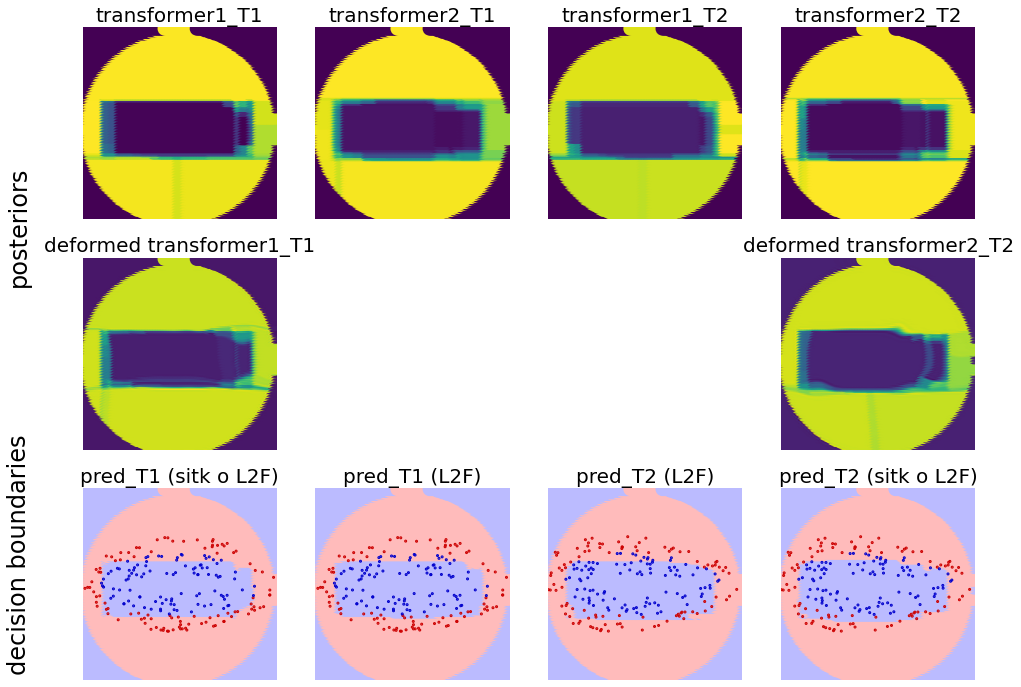

In [85]:
fig,axs = plt.subplots(3,4,figsize=(16,12))
colors = sns.color_palette('Dark2', n_colors=5)
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])
data = [task1pred1_deformed, '', '', task2pred2_deformed]
titles = ['deformed transformer1_T1','','', 'deformed transformer2_T2']
xylim = [-r,r]
for i in range(4):
    ax = axs[1,i]
    ax.axis('off')
    if data[i] != '':
        ax.scatter(xx,yy,c=data[i])
        ax.set_xlim(xylim); ax.set_ylim(xylim)
        ax.set_title(titles[i], fontsize=20)

data = [task1pred1_reshaped, task1pred2_reshaped, task2pred1_reshaped, task2pred2_reshaped]
titles = ['transformer1_T1', 'transformer2_T1', 'transformer1_T2', 'transformer2_T2']    
for i in range(4):
    ax = axs[0,i]
    ax.scatter(xx,yy,c=data[i])
    ax.set_xlim(xylim); ax.set_ylim(xylim)
    ax.axis('off')
    ax.set_title(titles[i], fontsize=20)

data = [np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0),
        np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0),
        np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0),
        np.mean([task2pred2_reshaped, task2pred2_deformed], axis=0)]
pt = [test_x1, test_x1, test_x2_rot, test_x2_rot]
labels = [test_y1, test_y1, test_y2, test_y2]
titles = ['pred_T1 (sitk o L2F)', 'pred_T1 (L2F)', 'pred_T2 (L2F)', 'pred_T2 (sitk o L2F)']
for i in range(4):
    ax = axs[2,i]
    ax.scatter(xx,yy,c=np.where(data[i]>0.5, 0, 1), cmap=cmap_light)
    clr = [colors[i] for i in labels[i]]
    ax.scatter(pt[i][:, 0], pt[i][:, 1], c=labels[i], s=1, cmap=cmap_bold)
    ax.set_title(titles[i], fontsize=20)
    ax.set_xlim(xylim); ax.set_ylim(xylim)
    ax.axis('off')

fig.text(0.07,0.65, 'posteriors', rotation=90, ha='center', va='center')
fig.text(0.07,0.27, 'decision boundaries', rotation=90, ha='center', va='center')

#### plot OT results

In [297]:
errors = np.zeros(10,dtype=float)
uf_task1 = uf.predict(test_x1, transformer_ids=[0], task_id=0)
l2f_task1 = l2f.predict(test_x1, task_id=0)
uf_task2 = uf.predict(test_x2_rot, transformer_ids=[1], task_id=1)
l2f_task2 = l2f.predict(test_x2_rot, task_id=1)

# UF
errors[0] = 1 - np.mean(uf_task1 == test_y1)
errors[1] = 1 - np.mean(uf_task2 == test_y2)
# L2F
errors[2] = 1 - np.mean(l2f_task1 == test_y1)
errors[3] = 1 - np.mean(l2f_task2 == test_y2)
errors

array([0.095, 0.08 , 0.1  , 0.105, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ])

In [275]:
test_grid_ori, g = to_test_grid(0, 75)
# OP = OrthogonalProcrustes()
# deformed_x1 = OP.fit_transform(test_grid_ori, test_grid_trans)
# OP = OrthogonalProcrustes()
# deformed_x2 = OP.fit_transform(test_grid_trans, test_grid_ori)



In [298]:
# Sinkhorn Transport
# ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1.0, tol=10e-15)
# ot_sinkhorn.fit(Xs=test_grid_ori, Xt=test_grid_trans)
# deformed_x1 = ot_sinkhorn.transform(Xs=test_grid_ori)
# # deformed_x2 = ot_sinkhorn.inverse_transform(Xt=test_grid_trans)


ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1.0, tol=10e-15)
ot_sinkhorn.fit(Xs=test_x1, Xt=test_x2_rot)
deformed_x1 = ot_sinkhorn.transform(Xs=test_x1)
deformed_x2 = ot_sinkhorn.inverse_transform(Xt=test_x2_rot)


# # EMD Transport with Laplacian regularization
# ot_emd_laplace = ot.da.EMDLaplaceTransport(
#     reg_lap=0.5, reg_src=1, tol=1e-15, max_iter=500
# )
# ot_emd_laplace.fit(Xs=test_x1, Xt=test_x2_rot)
# deformed_x1 = ot_emd_laplace.transform(Xs=test_x1)
# deformed_x2 = ot_emd_laplace.inverse_transform(Xt=test_x2_rot)

# idx1 = np.argmax(ot_sinkhorn.coupling_, axis=1)

In [276]:
SP = SeedlessProcrustes(optimal_transport_lambda=1.0, optimal_transport_eps=10e-15,
                       optimal_transport_num_reps=10)
deformed_x1 = SP.fit_transform(test_x1, test_x2_rot)
Q_ = SP.Q_
test_grid_trans = np.matmul(test_grid_ori, Q_)
# SP = SeedlessProcrustes()
# deformed_x2 = SP.fit_transform(test_x2_rot, test_x1)

# SP = SeedlessProcrustes(optimal_transport_lambda=1.0, optimal_transport_eps=10e-15,
#                        optimal_transport_num_reps=50)
# deformed_x1 = SP.fit_transform(test_grid_ori, test_grid_trans)
# SP = SeedlessProcrustes(optimal_transport_lambda=0.2, optimal_transport_eps=10e-15)
# deformed_x2 = SP.fit_transform(test_x2_rot, test_x1)

In [218]:
OP = OrthogonalProcrustes()
deformed_x1 = OP.fit_transform(test_grid_ori, test_grid_trans)

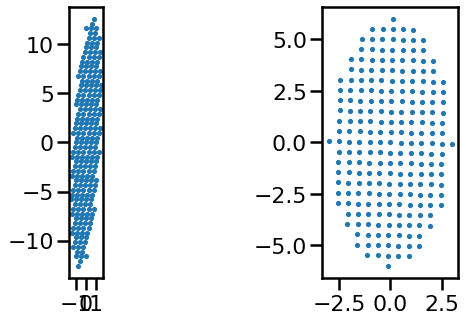

In [258]:
fig,axs = plt.subplots(1,2, figsize=(10,5))
ax = axs[0]
ax.scatter(g[:,0], g[:,1], s=10)
ax.set_aspect('equal', adjustable='box')
# ax = axs[1]
# ax.scatter(test_x2_rot[:,0], test_x2_rot[:,1], s=10)
# ax.set_aspect('equal', adjustable='box')
# # ax = axs[2]
# # ax.scatter(deformed_x2[:,0], deformed_x2[:,1], s=10)
# # ax.set_aspect('equal', adjustable='box')
ax = axs[1]
ax.scatter(test_grid_trans[:,0], test_grid_trans[:,1], s=10)
ax.set_aspect('equal', adjustable='box')

In [259]:
# L2F
l2f_task1_pos = generate_posteriors(test_grid_ori, 0, l2f, [0,1])
l2f_task2_pos = generate_posteriors(test_grid_trans, 1, l2f, [0,1])

uf_task1_pos = generate_posteriors(test_grid_ori, 0, uf, [0])
uf_task2_pos = generate_posteriors(test_grid_trans, 1, uf, [1])

errors = np.zeros(6, dtype=float)
# L2F
l2f_pred_task1 = np.mean([l2f_task1_pos[0], l2f_task1_pos[1]], axis=0)
l2f_task1 = vote_to_pred(l2f_pred_task1[:,0], test_x1, test_grid_ori)
errors[2] = 1-np.mean(np.argmax(l2f_task1, axis=1) == test_y1)
l2f_pred_task2 = np.mean([l2f_task2_pos[0], l2f_task2_pos[1]], axis=0)
l2f_task2 = vote_to_pred(l2f_pred_task2[:,0], test_x2_rot, test_grid_trans)
errors[3] = 1-np.mean(np.argmax(l2f_task2, axis=1) == test_y2)
# UF
uf_task1 = vote_to_pred(uf_task1_pos[0][:,0], test_x1, test_grid_ori)
errors[0] = 1-np.mean(np.argmax(uf_task1, axis=1) == test_y1)
uf_task2 = vote_to_pred(uf_task2_pos[0][:,0], test_x2_rot, test_grid_trans)
errors[1] = 1-np.mean(np.argmax(uf_task2, axis=1) == test_y2)
errors

array([0.145, 0.37 , 0.145, 0.39 , 0.   , 0.   ])

In [234]:
tree = BallTree(test_grid_trans)
idx1 = tree.query(np.matmul(test_grid_ori,Q_).reshape((-1,2)), k=1, return_distance=False).reshape((-1,))
idx2 = np.argsort(idx1)
idx1

array([220, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
       202, 203, 204, 205, 206, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  4

In [260]:
idx1=np.arange(221)
idx2 = np.argsort(idx1)

In [262]:
# task1pred1_deformed = vote_to_pred(l2f_task1_pos[0][:,0][idx2], test_x2_rot, test_grid_trans)
# task2pred2_deformed = vote_to_pred(l2f_task2_pos[1][:,0][idx1], test_x1, test_grid_ori)
# print(1-np.mean(np.argmax(task2pred2_deformed, axis=1) == test_y1))
# print(1-np.mean(np.argmax(task1pred1_deformed, axis=1) == test_y2))
w = 1
# OT_task1 = np.average([vote_to_pred(l2f_task1_pos[0][:,0], test_x1, test_grid_ori),
#                        task2pred2_deformed], axis=0, weights=[w,1])
# OT_task2 = np.average([vote_to_pred(l2f_task2_pos[1][:,0], test_x2_rot, test_grid_trans),
#                        task1pred1_deformed], axis=0, weights=[w,1])

task1pred1_deformed = np.average([l2f_task2_pos[1][idx1], uf_task1_pos[0]], axis=0, weights=[1,w])
task2pred2_deformed = np.average([l2f_task1_pos[0][idx2], uf_task2_pos[0]], axis=0, weights=[1,w])

# task1pred1_deformed = np.mean([l2f_task1_pos[0], l2f_task1_pos[0]], axis=0)
# task2pred2_deformed = np.mean([l2f_task2_pos[1], l2f_task1_pos[0]], axis=0)
OT_task1 = vote_to_pred(task1pred1_deformed[:,0], test_x1, test_grid_ori)
OT_task2 = vote_to_pred(task2pred2_deformed[:,0], test_x2_rot, test_grid_trans)

errors[4] = 1-np.mean(np.argmax(OT_task1, axis=1) == test_y1)
errors[5] = 1-np.mean(np.argmax(OT_task2, axis=1) == test_y2)
errors

array([0.145, 0.37 , 0.145, 0.39 , 0.16 , 0.355])

In [299]:
l2f_task1 = generate_posteriors(test_x1, 0, l2f, [0,1])
l2f_task2 = generate_posteriors(test_x2_rot, 1, l2f, [0,1])

tree = BallTree(test_x2_rot)
idx1 = tree.query(deformed_x1.reshape((-1,2)), k=1, return_distance=False).reshape((-1,))
idx2 = np.argsort(idx1)
task1pred1_deformed = l2f_task1[0][idx2]
task2pred2_deformed = l2f_task2[1][idx1]
print(1-np.mean(np.argmax(task2pred2_deformed, axis=1) == test_y1))
print(1-np.mean(np.argmax(task1pred1_deformed, axis=1) == test_y2))
# OT_task1 = np.mean([l2f_task1[0], task2pred2_deformed], axis=0)
# OT_task2 = np.mean([l2f_task2[1], task1pred1_deformed], axis=0)
w = 1
OT_task1 = np.average([l2f_task1[0], task2pred2_deformed], axis=0, weights=[w,1])
OT_task2 = np.average([l2f_task2[1], task1pred1_deformed], axis=0, weights=[w,1])

errors[4] = 1-np.mean(np.argmax(OT_task1, axis=1) == test_y1)
errors[5] = 1-np.mean(np.argmax(OT_task2, axis=1) == test_y2)
errors

0.22499999999999998
0.42500000000000004


array([0.095, 0.08 , 0.1  , 0.105, 0.14 , 0.16 , 0.   , 0.   , 0.   ,
       0.   ])

Text(0.5, 1.0, 'Rigid transform (45deg)')

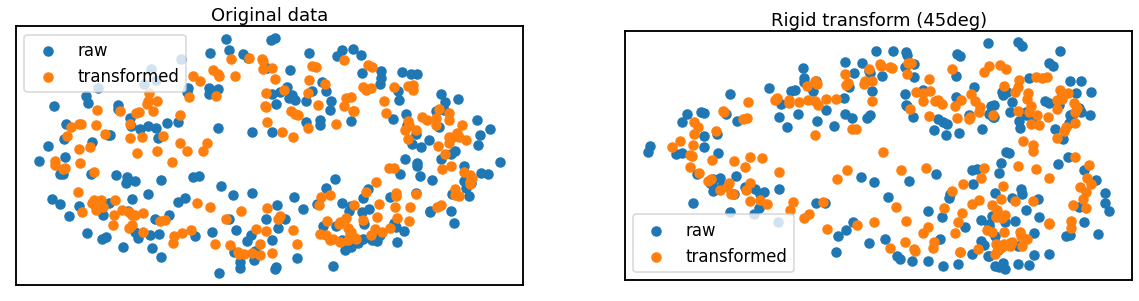

In [300]:
fig,axs = plt.subplots(1,2, figsize=(20,6))
ax = axs[0]
ax.scatter(test_x1[:,0],test_x1[:,1], label='raw')
ax.scatter(deformed_x2[:,0],deformed_x2[:,1], label='transformed')
ax.set_aspect('equal', adjustable='box')
ax.set(yticklabels='', yticks=[], xticklabels='', xticks=[])
ax.legend()
ax.set_title('Original data')
ax = axs[1]
ax.scatter(test_x2_rot[:,0],test_x2_rot[:,1], label='raw')
ax.scatter(deformed_x1[:,0],deformed_x1[:,1], label='transformed')
ax.set_aspect('equal', adjustable='box')
ax.set(yticklabels='', yticks=[], xticklabels='', xticks=[])
ax.legend()
ax.set_title('Nonlinear transform (45deg)')

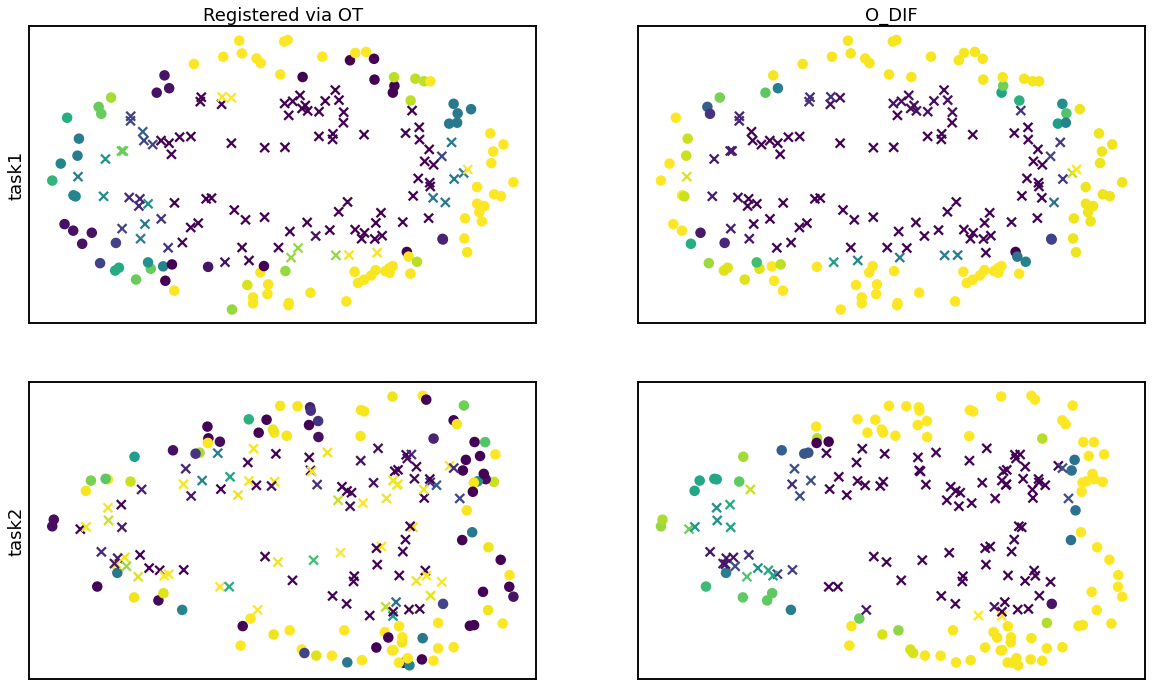

In [301]:
fig,axs = plt.subplots(2,2, figsize=(20,12))
m = ['o','x']
labels = [test_y1, test_y2]
data = [test_x1, test_x2_rot]
pred = [[l2f_task2[1][idx1], l2f_task1[0]],[l2f_task1[0][idx2], l2f_task2[1]]]
titles = ['Registered via OT', 'O_DIF']
ylabels = ['task1', 'task2']
for i in range(2):
    idx = np.where(labels[i] == 0)
    axs[i,0].scatter(data[i][idx,0], data[i][idx,1], c=pred[i][0][idx,0],
              marker=m[0])
    axs[i,1].scatter(data[i][idx,0], data[i][idx,1], c=pred[i][1][idx,0],
              marker=m[0])
    idx = np.where(labels[i] == 1)
    axs[i,0].scatter(data[i][idx,0], data[i][idx,1], c=pred[i][0][idx,0],
              marker=m[1])
    axs[i,1].scatter(data[i][idx,0], data[i][idx,1], c=pred[i][1][idx,0],
              marker=m[1])
    axs[i,0].set(yticklabels='', yticks=[], xticklabels='', xticks=[])
    axs[i,1].set(yticklabels='', yticks=[], xticklabels='', xticks=[])
    axs[i,0].set_ylabel(ylabels[i])
    if i == 0:
        axs[i,0].set_title(titles[0])
        axs[i,1].set_title(titles[1])

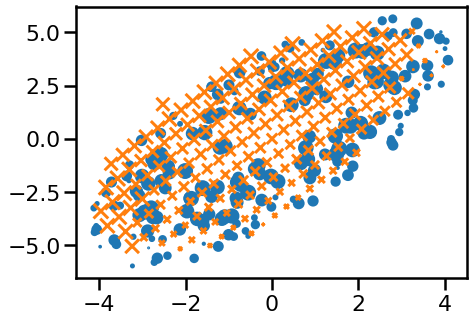

In [69]:
fig,ax = plt.subplots(1, figsize=(7,5))
idx = np.argsort(test_y2)
ax.scatter(test_x2_rot[idx,0], test_x2_rot[idx,1], s=range(len(test_x1)), marker='o')
ax.scatter(deformed_x1[idx,0], deformed_x1[idx,1], s=idx2[idx], marker='x')

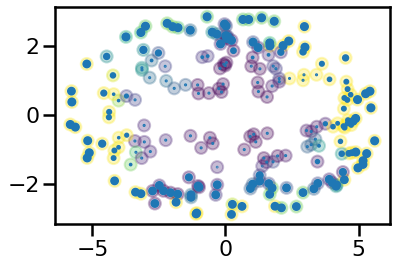

In [69]:
plt.scatter(test_x1[:,0], test_x1[:,1], c=l2f_task2[1][idx1][:,0], alpha=0.3)
plt.scatter(test_x1[:,0], test_x1[:,1], s=l2f_task1[0][:,0]*50)

In [71]:
idx1 = np.argmax(ot_sinkhorn.coupling_, axis=1)
idx2 = np.argsort(idx1)
np.vstack((np.argmax(l2f_task2[1][idx1],axis=1), np.argmax(l2f_task1[0],axis=1)))

array([[1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 1],
       [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 

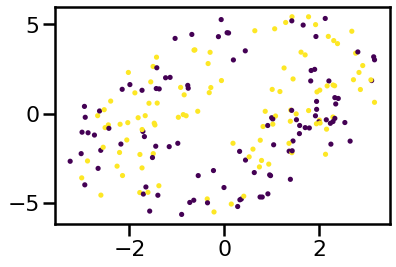

In [22]:
# plt.scatter(test_x1[:,0], test_x1[:,1],
#                  c=np.argmax(task2pred2_deformed, axis=1), s=10)
plt.scatter(test_x2_rot[:,0], test_x2_rot[:,1],
                 c=np.argmax(task1pred1_deformed, axis=1), s=10)

In [433]:
s = np.array([[1,0],[2,0],[0,0]])
t = np.array([[3,3],[0,0],[1,1]])
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=.1, tol=10e-11)
ot_sinkhorn.fit(Xs=s, Xt=t)

# transport source samples onto target samples
deformed_x1 = ot_sinkhorn.transform(Xs=s)
deformed_x2 = ot_sinkhorn.inverse_transform(Xt=t)
print(deformed_x1)
print(deformed_x2)

[[9.99952763e-01 9.99952763e-01]
 [2.99991661e+00 2.99991661e+00]
 [4.36303532e-05 4.36303532e-05]]
[[2.00000000e+00 0.00000000e+00]
 [4.72368146e-05 0.00000000e+00]
 [9.99998065e-01 0.00000000e+00]]


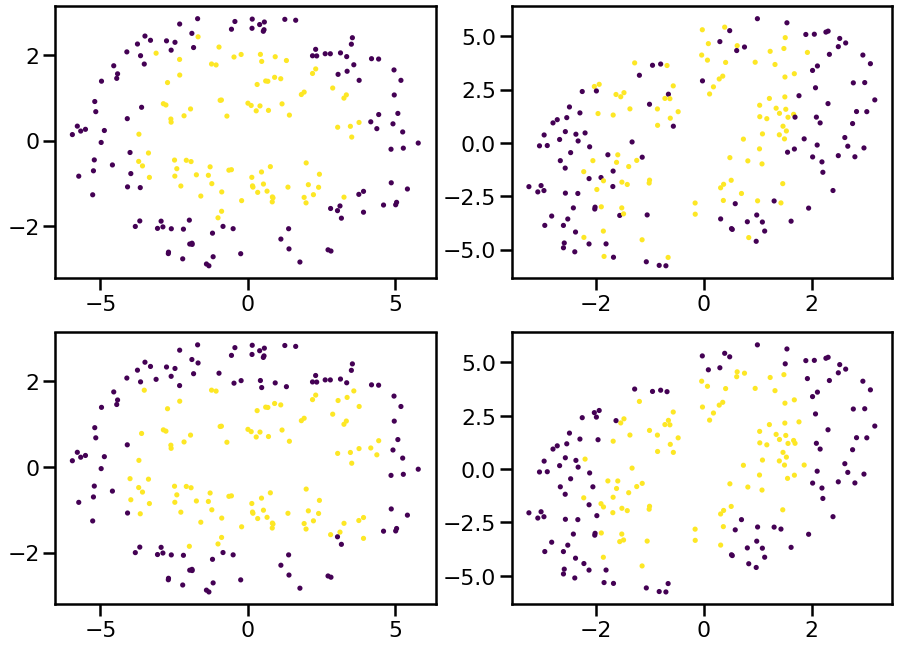

In [445]:
fig, axs = plt.subplots(2,2, figsize=(15,11))
axs[0,0].scatter(test_x1[:,0], test_x1[:,1],
            c=np.argmax(OT_task1, axis=1), s=10)
axs[0,1].scatter(test_x2_rot[:,0], test_x2_rot[:,1],
            c=np.argmax(OT_task2, axis=1), s=10)
axs[1,0].scatter(test_x1[:,0], test_x1[:,1],
            c=np.argmax(np.mean([l2f_task1[0], l2f_task1[1]], axis=0),
                        axis=1), s=10)
axs[1,1].scatter(test_x2_rot[:,0], test_x2_rot[:,1],
            c=np.argmax(np.mean([l2f_task2[1], l2f_task2[0]], axis=0),
                        axis=1), s=10)

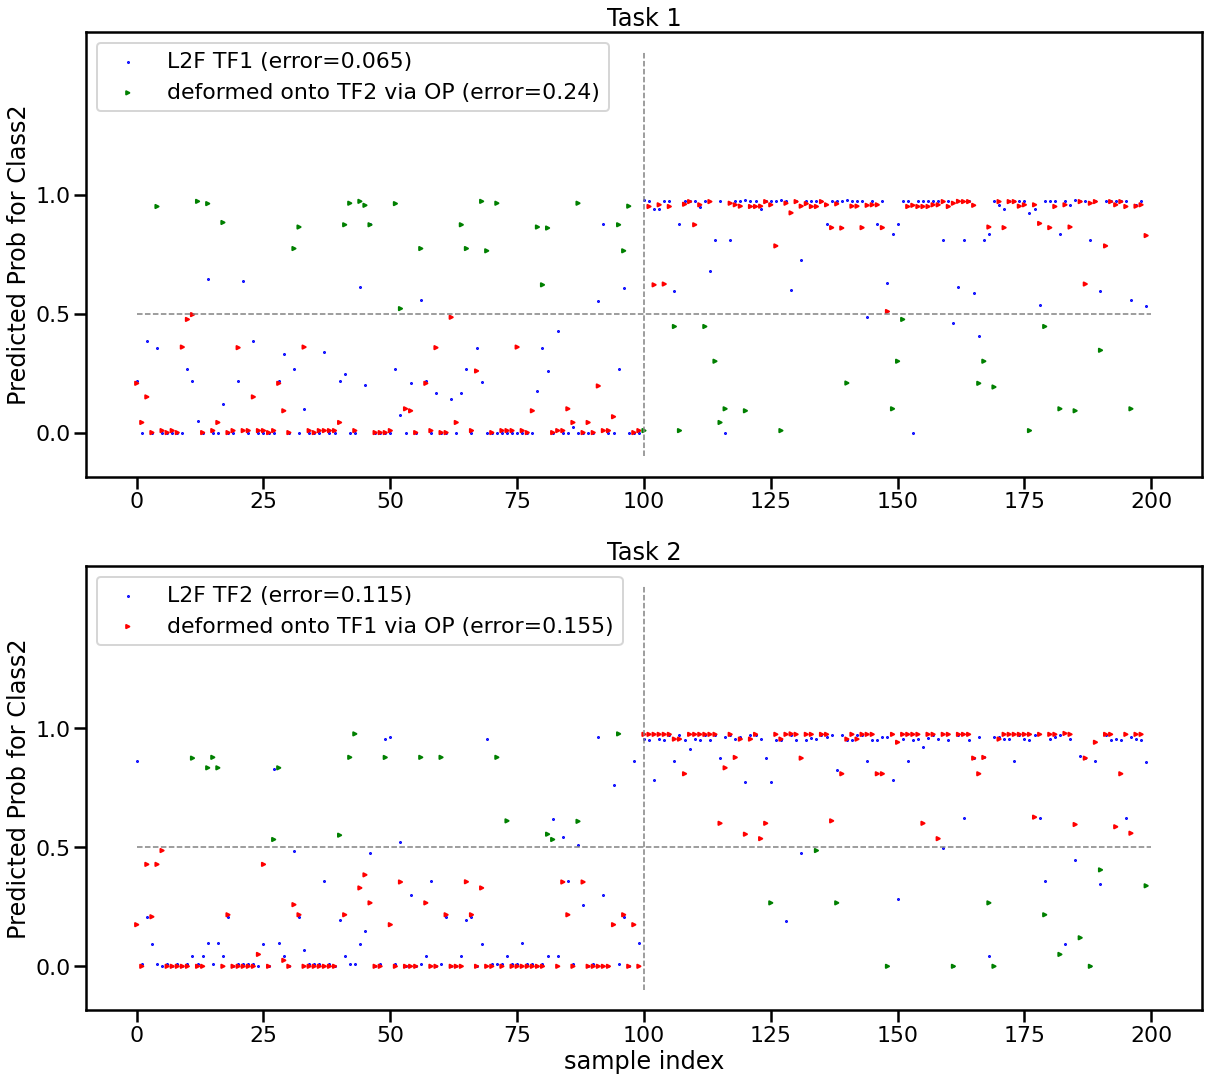

In [305]:
fig, axs = plt.subplots(2,1, figsize=(20, 18))
data = [[l2f_task1[0], l2f_task2[1]],
        [task1pred1_deformed, task2pred2_deformed]]
tests = [[test_x1,test_y1], [test_x2_rot, test_y2]]
n_sample = 200
for id in range(len(data)):
    ax = axs[id]
    idx = np.argsort(tests[id][1])
    n = int(len(idx)/2)
    l2f_pos = data[0][id]
    l2f_sorted = l2f_pos[:,1][idx[:n]]
    ax.scatter(range(n), l2f_sorted, s=1, c='b', marker='o')
    l2f_sorted = l2f_pos[:,1][idx[n:]]
    e1 = np.round(1 - np.mean(np.argmax(l2f_pos, axis=1) == tests[id][1]), 3)
    ax.scatter(np.arange(n)+n, l2f_sorted, s=1, c='b', marker='o',
               label='L2F TF%s (error=%s)'%(id+1,str(e1)))


    OT_pos = data[1][id]
    OT_sorted = OT_pos[:,1][idx[:n]]
    OT_sorted[OT_sorted>1] = 1
    OT_sorted[OT_sorted<0] = 0
    ax.scatter(range(n), OT_sorted, s=10,
               c=get_colors(['r','g'],np.argmax(OT_pos[idx[:n]],axis=1)), marker='>')
#     ax.scatter(np.arange(n), OT_sorted, s=10, c='r', marker='>')
    OT_sorted = OT_pos[:,1][idx[n:]]
    e2 = np.round(1 - np.mean(np.argmax(OT_pos, axis=1) == tests[id][1]), 3)
#     ax.scatter(np.arange(n)+n, OT_sorted, s=10, c='r', marker='>',
#                label='deformed onto TF%s via OP (error=%s)'%((2-id),str(e2)))
    ax.scatter(np.arange(n)+n, OT_sorted, s=10,
               c=get_colors(['r','g'],np.argmin(OT_pos[idx[n:]],axis=1)), marker='>',
              label='deformed onto TF%s via OP (error=%s)'%((2-id),str(e2)))


#     ylim=([-0.1, 1.6]), yticks=[0,0.5,1],
    ax.set(yticks=[0,0.5,1], ylabel='Predicted Prob for Class2', title='Task %s'%str(id+1))
    ax.hlines(0.5, 0,n_sample, colors='gray', linestyles='dashed',linewidth=1.5)
    ax.vlines(n_sample/2, -0.1,1.6, colors='gray', linestyles='dashed',linewidth=1.5)
    ax.legend(loc='upper left')
    if id == 1:
        ax.set_xlabel('sample index')
# plt.savefig('OP-tran2-75deg-6-66-82-8-62-7')

<ipython-input-317-a1a2aabe88a1>:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if data[i] != '':


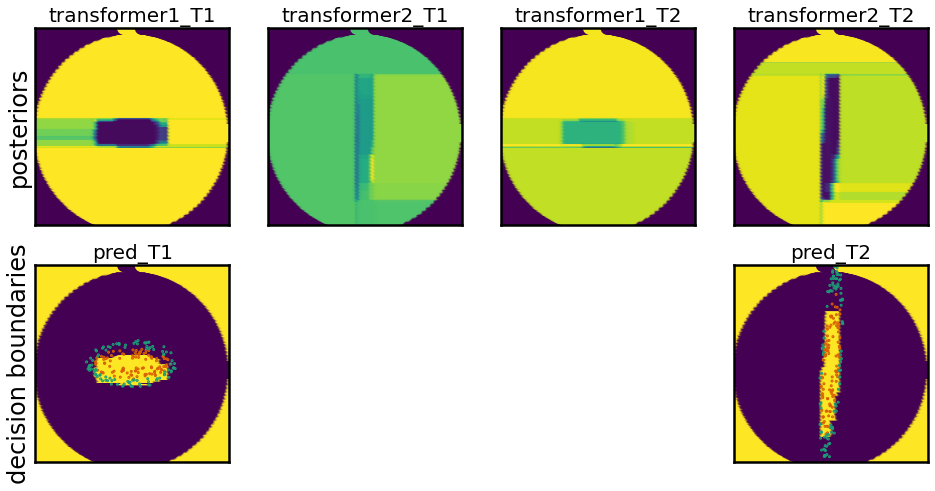

In [317]:
fig,axs = plt.subplots(2,4,figsize=(16,8))
colors = sns.color_palette('Dark2', n_colors=5)
xylim = [-r,r]

data = [task1pred1_reshaped, task1pred2_reshaped, task2pred1_reshaped, task2pred2_reshaped]
titles = ['transformer1_T1', 'transformer2_T1', 'transformer1_T2', 'transformer2_T2']    
for i in range(4):
    ax = axs[0,i]
    ax.scatter(xx,yy,c=data[i])
    ax.set_xlim(xylim); ax.set_ylim(xylim)
    ax.set(yticklabels='', yticks=[], xticklabels='', xticks=[])
    ax.set_title(titles[i], fontsize=20)
    if i == 0:
        ax.set_ylabel('posteriors')

data = [np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0),'','',
        np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0)]
pt = [test_x1, test_x1, test_x2_rot, test_x2_rot]
labels = [test_y1, test_y1, test_y2, test_y2]
titles = ['pred_T1', '', '', 'pred_T2']
for i in range(4):
    ax = axs[1,i]
    ax.set(yticklabels='', yticks=[], xticklabels='', xticks=[])
    if i == 0:
        ax.set_ylabel('decision boundaries')
    if data[i] != '':
        ax.scatter(xx,yy,c=np.where(data[i]>0.5, 0, 1))
        clr = [colors[i] for i in labels[i]]
        ax.scatter(pt[i][:, 0], pt[i][:, 1], c=clr, s=1)
        ax.set_title(titles[i], fontsize=20)
        ax.set_xlim(xylim); ax.set_ylim(xylim)
    else:
        ax.axis('off')

In [26]:
i = np.array([[0,1],[-3,3],[-1,10]])
(i - np.min(i)) / (np.max(i) - np.min(i))

array([[0.23076923, 0.30769231],
       [0.        , 0.46153846],
       [0.15384615, 1.        ]])

In [256]:
n_samples_source = 200
test_x1, test_y1 = generate_rand_ellipse(n_samples_source)
test_x2, test_y2 = generate_rand_ellipse(n_samples_source)
# test_x2_rot = rotate_data(test_x2, angle)
test_x2_rot = shear_data_rot(test_x2, angle)[:50,:]
# # aligner = SeedlessProcrustes(optimal_transport_lambda=0.2,
# #                              optimal_transport_eps=10e-9)
# aligner = OrthogonalProcrustes()
# # np.random.shuffle(test_x1)
np.random.shuffle(test_x2_rot)
# deformed_x1 = aligner.fit_transform(test_x1, test_x2_rot)
# # aligner = OrthogonalProcrustes()
# # deformed_task2 = aligner.fit_transform(l2f_task2_pos[1], l2f_task1_pos[0])


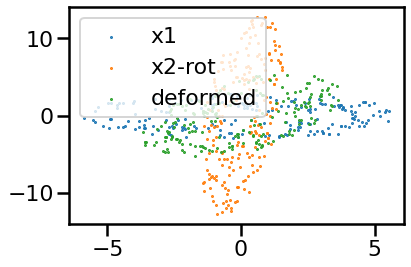

In [243]:
plt.scatter(test_x1[:,0],test_x1[:,1], label='x1', s=1)
plt.scatter(test_x2_rot[:,0],test_x2_rot[:,1], label='x2-rot', s=1)
plt.scatter(deformed_x1[:,0],deformed_x1[:,1], label='deformed', s=1)
plt.legend()

In [257]:
# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=.2)
ot_sinkhorn.fit(Xs=test_x1, Xt=test_x2_rot)

# # EMD Transport with Laplacian regularization
# ot_emd_laplace = ot.da.EMDLaplaceTransport(reg_lap=100, reg_src=1)
# ot_emd_laplace.fit(Xs=test_x1, Xt=test_x2_rot)

# transport source samples onto target samples
transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=test_x1)
transp_Xt_sinkhorn = ot_sinkhorn.inverse_transform(Xt=test_x2_rot)
# transp_Xs_emd_laplace = ot_emd_laplace.transform(Xs=test_x1)

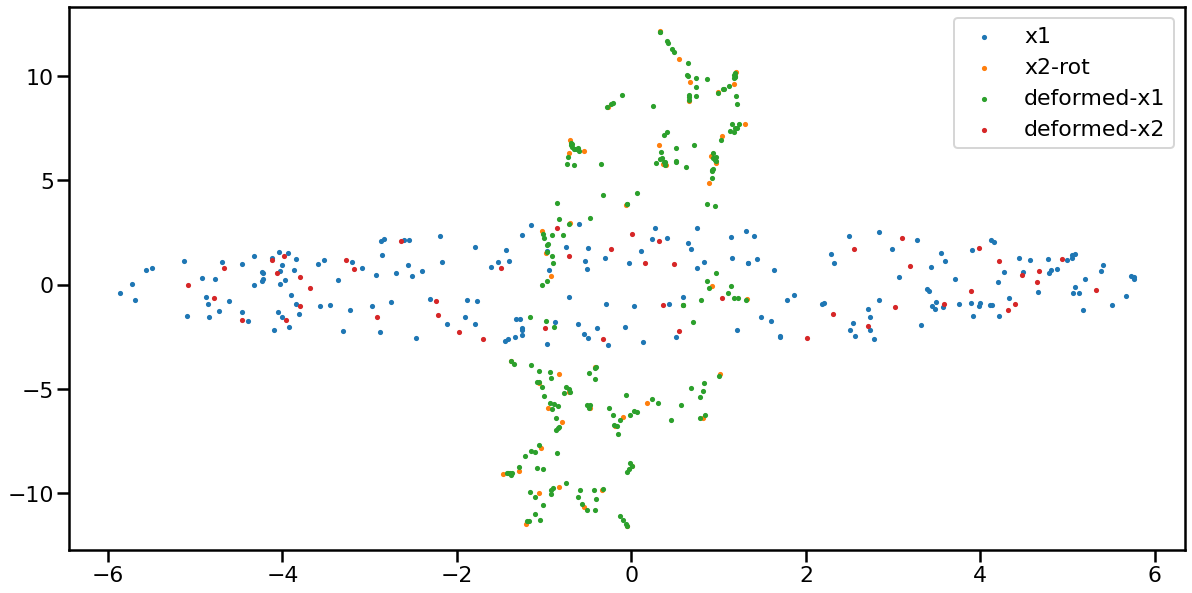

In [261]:
fig,ax = plt.subplots(1, figsize=(20,10))
ax.scatter(test_x1[:,0],test_x1[:,1], label='x1', s=10)
ax.scatter(test_x2_rot[:,0],test_x2_rot[:,1], label='x2-rot', s=10)
ax.scatter(transp_Xs_sinkhorn[:,0],transp_Xs_sinkhorn[:,1], label='deformed-x1', s=10)
ax.scatter(transp_Xt_sinkhorn[:,0],transp_Xt_sinkhorn[:,1], label='deformed-x2', s=10)

# plt.scatter(transp_Xs_emd_laplace[:,0],transp_Xs_emd_laplace[:,1], label='deformed', s=1)
ax.legend()


In [168]:
# orthogonal procrustes
aligner = OrthogonalProcrustes()
deformed_task1 = aligner.fit_transform(l2f_task1_pos[0], l2f_task2_pos[1])
aligner = OrthogonalProcrustes()
deformed_task2 = aligner.fit_transform(l2f_task2_pos[1], l2f_task1_pos[0])

deformed_task1_new = reshape_posteriors(inside, deformed_task1[:,0])
deformed_task2_new = reshape_posteriors(inside, deformed_task2[:,0])
pred_task1 = np.mean([task1pred1_reshaped, deformed_task1_new], axis=0)[inside]
OT_task1 = vote_to_pred(pred_task1, test_x1, test_grid)
errors[6] = 1 - np.mean(np.argmax(OT_task1, axis=1) == test_y1)
pred_task2 = np.mean([task2pred2_reshaped, deformed_task2_new], axis=0)[inside]
OT_task2 = vote_to_pred(pred_task2, test_x2_rot, test_grid)
errors[7] = 1 - np.mean(np.argmax(OT_task2, axis=1) == test_y2)
errors

array([0.06 , 0.066, 0.082, 0.08 , 0.   , 0.   , 0.062, 0.07 , 0.068,
       0.072])

In [162]:
data = [[l2f_task1_pos[0], l2f_task2_pos[1]], [deformed_task1, deformed_task2],
       [l2f_task1_pos[1], l2f_task2_pos[0]]]
tests = [[test_x1,test_y1], [test_x2_rot, test_y2]]
for i in [0,1]:
    print([1 - np.mean(np.argmax(vote_to_pred(data[0][i][:,0], tests[i][0], test_grid),
                                axis=1) == tests[i][1]),
    1 - np.mean(np.argmax(vote_to_pred(data[1][i][:,0], tests[i][0], test_grid),
                                axis=1) == tests[i][1])])

    print([1 - np.mean(np.argmax(vote_to_pred(np.mean([data[2][i],data[0][i]],axis=0)[:,0],
                                                     tests[i][0], test_grid), axis=1) == tests[i][1]),
    1 - np.mean(np.argmax(vote_to_pred(np.mean([data[0][i],data[1][i]],axis=0)[:,0],
                                             tests[i][0], test_grid), axis=1) == tests[i][1])])
    

[0.06399999999999995, 0.06000000000000005]
[0.08199999999999996, 0.062000000000000055]
[0.07599999999999996, 0.06999999999999995]
[0.07999999999999996, 0.06999999999999995]


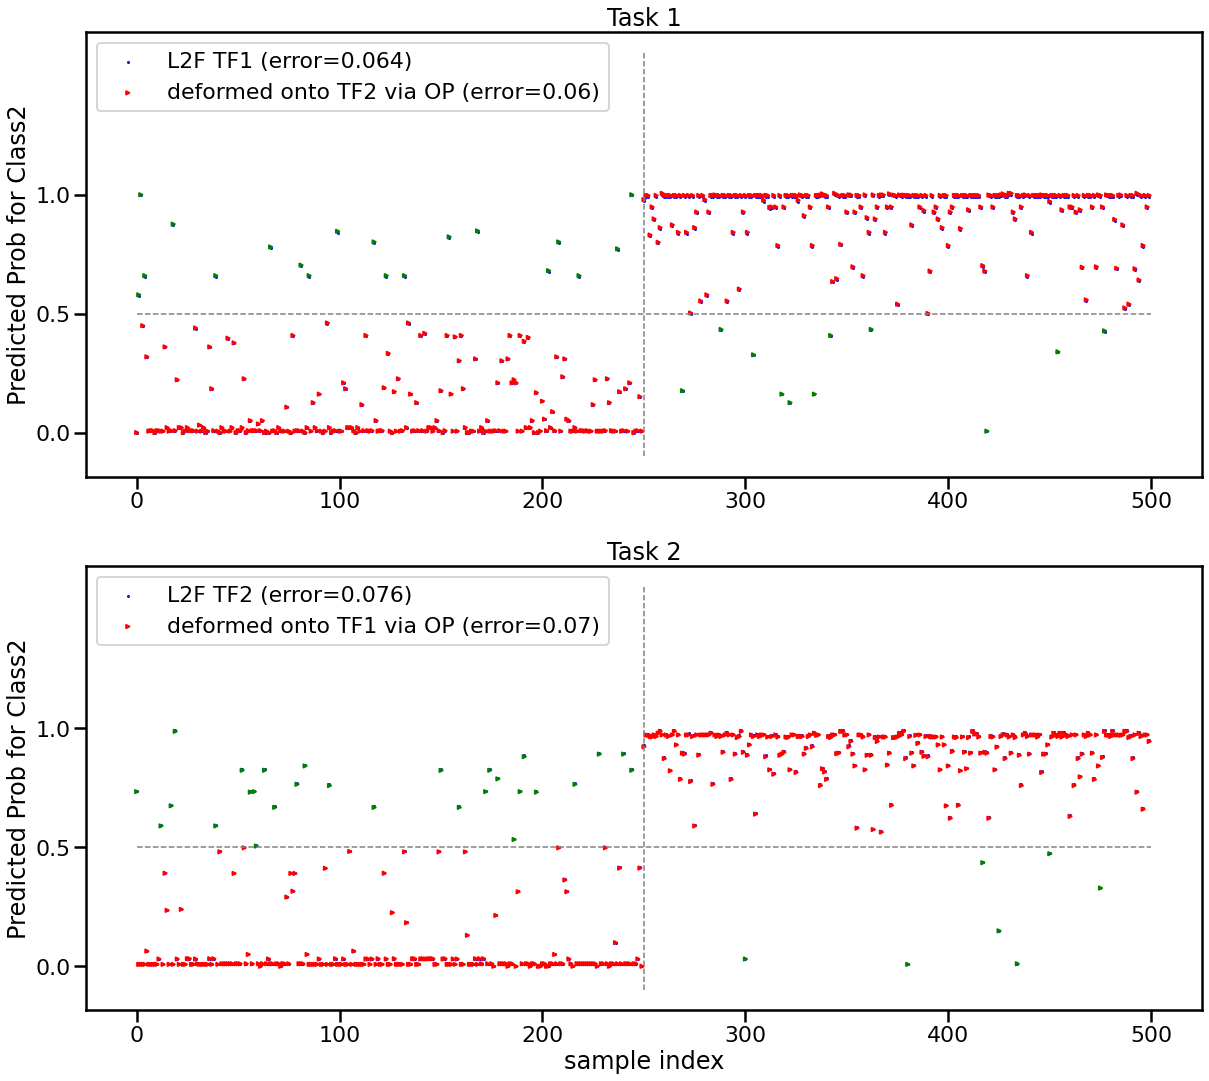

In [172]:
fig, axs = plt.subplots(2,1, figsize=(20, 18))
data = [[l2f_task1_pos[0], l2f_task2_pos[1]], [deformed_task1, deformed_task2]]
tests = [[test_x1,test_y1], [test_x2_rot, test_y2]]
n_sample = 500
for id in range(len(data)):
    ax = axs[id]
    idx = np.argsort(tests[id][1])
    n = int(len(idx)/2)
    l2f_pos = vote_to_pred(data[0][id][:,0], tests[id][0], test_grid)
    l2f_sorted = l2f_pos[:,1][idx[:n]]
    ax.scatter(range(n), l2f_sorted, s=1, c='b', marker='o')
    l2f_sorted = l2f_pos[:,1][idx[n:]]
    e1 = np.round(1 - np.mean(np.argmax(l2f_pos, axis=1) == tests[id][1]), 3)
    ax.scatter(np.arange(n)+n, l2f_sorted, s=1, c='b', marker='o',
               label='L2F TF%s (error=%s)'%(id+1,str(e1)))


    OT_pos = vote_to_pred(data[1][id][:,0], tests[id][0], test_grid)
    OT_sorted = OT_pos[:,1][idx[:n]]
    OT_sorted[OT_sorted>1] = 1
    OT_sorted[OT_sorted<0] = 0
    ax.scatter(range(n), OT_sorted, s=10,
               c=get_colors(['r','g'],np.argmax(OT_pos[idx[:n]],axis=1)), marker='>')
#     ax.scatter(np.arange(n), OT_sorted, s=10, c='r', marker='>')
    OT_sorted = OT_pos[:,1][idx[n:]]
    e2 = np.round(1 - np.mean(np.argmax(OT_pos, axis=1) == tests[id][1]), 3)
#     ax.scatter(np.arange(n)+n, OT_sorted, s=10, c='r', marker='>',
#                label='deformed onto TF%s via OP (error=%s)'%((2-id),str(e2)))
    ax.scatter(np.arange(n)+n, OT_sorted, s=10,
               c=get_colors(['r','g'],np.argmin(OT_pos[idx[n:]],axis=1)), marker='>',
              label='deformed onto TF%s via OP (error=%s)'%((2-id),str(e2)))


#     ylim=([-0.1, 1.6]), yticks=[0,0.5,1],
    ax.set(yticks=[0,0.5,1], ylabel='Predicted Prob for Class2', title='Task %s'%str(id+1))
    ax.hlines(0.5, 0,n_sample, colors='gray', linestyles='dashed',linewidth=1.5)
    ax.vlines(n_sample/2, -0.1,1.6, colors='gray', linestyles='dashed',linewidth=1.5)
    ax.legend(loc='upper left')
    if id == 1:
        ax.set_xlabel('sample index')
plt.savefig('OP-tran2-75deg-6-66-82-8-62-7')

In [164]:
def check_proc_vote(pos):
    ii = 0
    i = np.argmax(pos,axis=1)
    j =  pos>=0.5
    for k in range(len(i)):
        if (i[k]==0 and j[k] is True) or (i[k]==1 and j[k] is False):
            ii += 1
    return ii
check_proc_vote(OT_pos)

0

In [173]:
l2f_task1 = generate_posteriors(test_x1, 0, l2f, [0,1])
l2f_task2 = generate_posteriors(test_x2_rot, 1, l2f, [0,1])
# procrustes
aligner = SeedlessProcrustes(iterative_num_reps=500)
aligner.fit(l2f_task1[0], l2f_task2[1])
Q_ = aligner.initial_Q
aligner = SeedlessProcrustes(iterative_num_reps=500, init='custom', initial_Q=Q_)
deformed_task1 = aligner.fit_transform(l2f_task1[0], l2f_task2[1])

aligner1 = SeedlessProcrustes(iterative_num_reps=500)
aligner1.fit(l2f_task2[1], l2f_task1[0])
Q_ = aligner1.initial_Q
aligner1 = SeedlessProcrustes(iterative_num_reps=500, init='custom', initial_Q=Q_)
deformed_task2 = aligner1.fit_transform(l2f_task2[1], l2f_task1[0])

l2f_pred_task1_proc = np.mean([l2f_task1[0], deformed_task1], axis=0)
errors[8] = 1 - np.mean(np.argmax(l2f_pred_task1_proc, axis=1) == test_y1)
l2f_pred_task2_proc = np.mean([l2f_task2[1], deformed_task2], axis=0)
errors[9] = 1 - np.mean(np.argmax(l2f_pred_task2_proc, axis=1) == test_y2)
errors

array([0.06 , 0.066, 0.082, 0.08 , 0.   , 0.   , 0.062, 0.07 , 0.068,
       0.072])

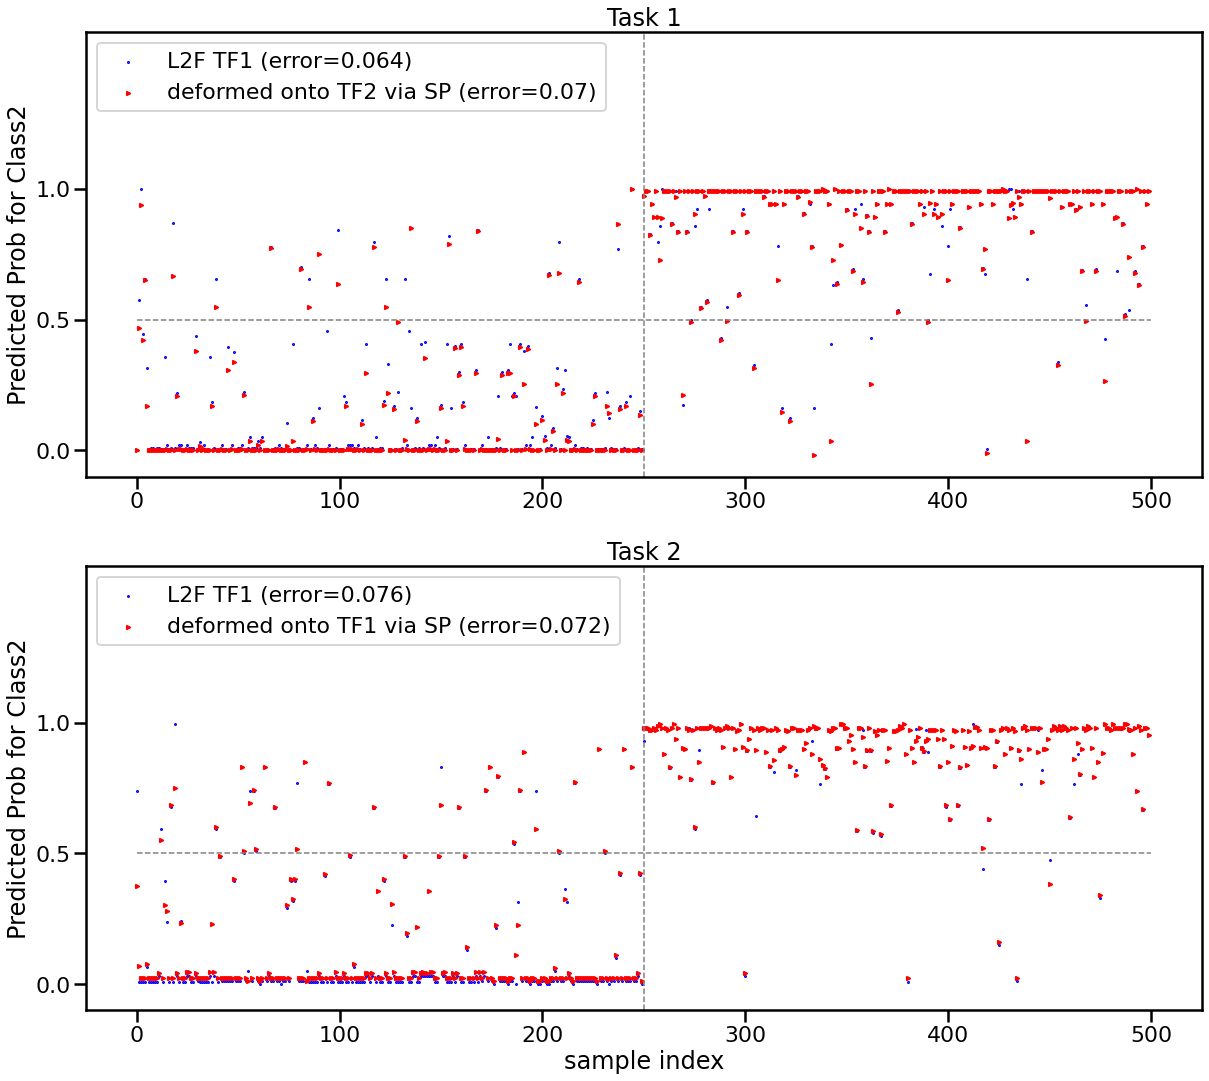

In [174]:
fig, axs = plt.subplots(2,1, figsize=(20, 18))

data = [[l2f_task1_pos[0], l2f_task2_pos[1]], [deformed_task1, deformed_task2]]
tests = [[test_x1,test_y1], [test_x2_rot, test_y2]]
for id in range(len(data)):
    ax = axs[id]
    idx = np.argsort(tests[id][1])
    n = int(len(idx)/2)
    l2f_pos = vote_to_pred(data[0][id][:,0], tests[id][0], test_grid)
    l2f_sorted = l2f_pos[:,1][idx[:n]]
    ax.scatter(range(n), l2f_sorted, s=1, c='b', marker='o')
    l2f_sorted = l2f_pos[:,1][idx[n:]]
    e1 = np.round(1 - np.mean(np.argmax(l2f_pos, axis=1) == tests[id][1]), 3)
    ax.scatter(np.arange(n)+n, l2f_sorted, s=1, c='b', marker='o', label='L2F TF1 (error=%s)'%str(e1))


    OT_pos = data[1][id]
    OT_sorted = OT_pos[:,1][idx[:n]]
    OT_sorted[OT_sorted>1] = 1
    OT_sorted[OT_sorted<0] = 0
    # ax.scatter(range(n), OT_sorted, s=10,
    #            c=get_colors(['r','g'],np.argmax(OT_pos[idx[:n]],axis=1)), marker='>')
    ax.scatter(np.arange(n), OT_sorted, s=10, c='r', marker='>')
    OT_sorted = OT_pos[:,1][idx[n:]]
    e2 = np.round(1 - np.mean(np.argmax(OT_pos, axis=1) == tests[id][1]), 3)
    ax.scatter(np.arange(n)+n, OT_sorted, s=10, c='r', marker='>',
               label='deformed onto TF%s via SP (error=%s)'%((2-id),str(e2)))


    ax.set(ylim=([-0.1, 1.6]), yticks=[0,0.5,1],
           ylabel='Predicted Prob for Class2', title='Task %s'%str(id+1))
    ax.hlines(0.5, 0,n_sample, colors='gray', linestyles='dashed',linewidth=1.5)
    ax.vlines(n_sample/2, -0.1,1.6, colors='gray', linestyles='dashed',linewidth=1.5)
    ax.legend(loc='upper left')
    if id == 1:
        ax.set_xlabel('sample index')
plt.savefig('SP-trans2-6-66-82-8-68-72')

In [135]:
context = sns.plotting_context(context="poster", font_scale=1)
sns.set_context(context)

In [22]:
def run():
    angles = [105,120]
    errors = np.empty((len(angles), 6))
    for i,angle in enumerate(angles):
        errors[i,:] = exp_reg_pos_asImg_sitk(angle, n_samples_source=200)
        
    return errors

In [24]:
rep = 1000
e = Parallel(n_jobs=30, verbose=1)(delayed(run)() for _ in range(rep))


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed: 19.4min
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed: 51.4min
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed: 94.7min
[Parallel(n_jobs=30)]: Done 1000 out of 1000 | elapsed: 125.5min finished


In [27]:
e_avg = np.mean(e, axis=0)
e_avg

array([[0.09453 , 0.107035, 0.09322 , 0.11279 , 0.09871 , 0.12944 ],
       [0.09493 , 0.13775 , 0.09535 , 0.15277 , 0.09083 , 0.130625]])

In [176]:
np.log2(400)

8.643856189774725

##### estimate TransformParameters for angle = 45

In [89]:
def convert_param(param):
    p = [float(param[i]) for i in range(len(param))]
    
    return np.array(p)
        
def modify_transform_map(param, name):
    f = open('TransformParameters_template.txt','r')
    filedata = f.read()
    f.close()

    newdata = filedata.replace("(TransformParameters)",
                               "(TransformParameters "
                               + " " + str(param[0]) + " " + str(param[1]) + " " + str(param[2]) +")")

    f = open('TransformParameters_init' + name + '.txt','w')
    f.write(newdata)
    f.close()

In [87]:
rep = 100
e_and_p = Parallel(n_jobs=30, verbose=1)(delayed(exp_reg_pos_asImg_sitk)(30) for _ in range(rep))


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:  2.8min finished


In [90]:
p1_all = [convert_param(e_and_p[i][1][0]) for i in range(len(e_and_p))]
p2_all = [convert_param(e_and_p[i][1][1]) for i in range(len(e_and_p))]
p1 = np.mean(p1_all, axis=0)
p2 = np.mean(p2_all, axis=0)

In [93]:
modify_transform_map(p1,'30_1')
modify_transform_map(p2,'30_2')

In [97]:
exp_reg_pos_asImg_OT(15)

array([0.12, 0.15, 0.16, 0.13, 0.14, 0.15])